In [44]:
import pickle 
import sys  
import os
import re  
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem

from rdkit import RDLogger
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from IPython.display import display

from collections import Counter, defaultdict
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Optional, Union
from scipy import sparse
from tqdm import tqdm

from rxnebm.data.preprocess import clean_smiles 

## inject rxn_type

In [4]:
proposals_typed_all_phases = {}
rxn_types_all_phases = {}
mapped_rxn_smi_to_rxn_type = {}

proposal_prefixes = [
    'retrosim_200topk_200maxk_noGT',
    'GLN_retrain_200topk_200maxk_noGT',
    'retroxpert_200topk_200maxk_noGT'
]
for proposal_prefix in proposal_prefixes:
    print(f'Processing {proposal_prefix}')
    time.sleep(0.5)
    for phase in ['test']: # 'train', 'valid', 
        USPTO_50k_typed_df = pd.read_csv(f'rxnebm/data/original_data/typed_schneider50k/schneider50k_typed_{phase}.csv', index_col=None, dtype='str')
        USPTO_50k_typed = USPTO_50k_typed_df.drop(['id'], axis=1).values

        pt = re.compile(r":(\d+)]")
        too_small = 0
        for row in tqdm(USPTO_50k_typed, desc=f'Mapping atom-mapped rxn_smi (key) to rxn_type (value) for {phase}'):
            rxn_type, rxn_smi = row 
            if rxn_smi in mapped_rxn_smi_to_rxn_type:
                continue 

            # clean original rxn smi using code from clean_smiles.clean_rxn_smis_50k_one_phase() 
            all_rcts_smi, all_reag_smi, prods_smi = rxn_smi.split(">")
            rids = ",".join(sorted(re.findall(pt, all_rcts_smi)))
            pids = ",".join(sorted(re.findall(pt, prods_smi)))
            if rids != pids:  # atom mapping is not 1:1, but for rxn-ebm, this is not important
                bad_mapping += 1
                bad_mapping_idxs.append(i)

            all_rcts_mol = [Chem.MolFromSmiles(smi) for smi in all_rcts_smi.split(".")]

            for prod_smi in prods_smi.split("."):
                mol_prod = Chem.MolFromSmiles(prod_smi)
                if mol_prod is None:  # rdkit is not able to parse the product, critical!
                    bad_prod += 1
                    bad_prod_idxs.append(i)
                    continue

                # check if all atoms in product have atom mapping, but for
                # rxn-ebm, this is not important
                if not all(
                    [a.HasProp("molAtomMapNumber") for a in mol_prod.GetAtoms()]
                ):
                    missing_map += 1
                    missing_map_idxs.append(i)

                rxn_smi = clean_smiles.move_reagents(
                    mol_prod=mol_prod,
                    reactants=all_rcts_mol,
                    original_reagents=all_reag_smi,
                    keep_reagents=False,
                    keep_all_rcts=False,
                    remove_rct_mapping=True,
                )

                temp_rxn_smi = clean_smiles.remove_mapping(rxn_smi, keep_reagents=False)
                if len(temp_rxn_smi.split(">")[-1]) < 3:  # check length of product SMILES string
                    too_small += 1  # e.g. 'Br', 'O', 'I' 
                    continue  

                mapped_rxn_smi_to_rxn_type[rxn_smi] = int(rxn_type)
        print('Too small: ', too_small)

        with open(f'rxnebm/data/cleaned_data/50k_clean_rxnsmi_noreagent_allmapped_{phase}.pickle', 'rb') as f:
            clean_50k_phase = pickle.load(f)

        rxn_types_phase = []

        for mapped_rxn_smi in clean_50k_phase:
            rxn_types_phase.append(mapped_rxn_smi_to_rxn_type[mapped_rxn_smi])

        rxn_types_all_phases[phase] = rxn_types_phase
        print(f'Obtained rxn types for {phase}')

        proposals_phase = pd.read_csv(
            f'rxnebm/data/cleaned_data/{proposal_prefix}_{phase}.csv', 
            index_col=None, dtype='str'
        )
        proposals_phase['rxn_type'] = rxn_types_all_phases[phase]
        cols = proposals_phase.columns.tolist()
        new_cols = [cols[-1]] + cols[:-1] # put rxn_type column as first column
        proposals_phase = proposals_phase[new_cols]
        proposals_phase.to_csv(
            f'rxnebm/data/cleaned_data/{proposal_prefix}_typed_{phase}.csv', 
            index=False
        )
        proposals_typed_all_phases[phase] = proposals_phase

Mapping atom-mapped rxn_smi (key) to rxn_type (value) for test:   1%|▏              | 59/5007 [00:00<00:08, 582.78it/s]

Processing retrosim_200topk_200maxk_noGT


Mapping atom-mapped rxn_smi (key) to rxn_type (value) for test: 100%|█████████████| 5007/5007 [00:08<00:00, 570.03it/s]


Too small:  0
Obtained rxn types for test


Mapping atom-mapped rxn_smi (key) to rxn_type (value) for test: 100%|██████████| 5007/5007 [00:00<00:00, 167840.54it/s]

Processing GLN_retrain_200topk_200maxk_noGT
Too small:  0
Obtained rxn types for test



Mapping atom-mapped rxn_smi (key) to rxn_type (value) for test: 100%|██████████| 5007/5007 [00:00<00:00, 172774.23it/s]

Processing retroxpert_200topk_200maxk_noGT
Too small:  0
Obtained rxn types for test


## Eyeball rxn_smi w/in rxn_type + proposer ranks

In [ ]:
phase = 'test'
gln_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_retrain_200topk_200maxk_noGT_typed_{phase}.csv', 
                        index_col=None, dtype='str')
retrosim_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200topk_200maxk_noGT_typed_{phase}.csv', 
                             index_col=None, dtype='str')
retroxpert_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_noGT_typed_{phase}.csv', 
                             index_col=None, dtype='str')

### rxn_type = 4 across all 3 proposers (all 3 models do worst here)

In [61]:
rxn_type = 4
gln_props = gln_props_df.fillna('9999')
gln_props = gln_props[gln_props.rxn_type == str(rxn_type)]
retrosim_props = retrosim_props_df.fillna('9999')
retrosim_props = retrosim_props[retrosim_props.rxn_type == str(rxn_type)]
retroxpert_props = retroxpert_props_df.fillna('9999')
retroxpert_props = retroxpert_props[retroxpert_props.rxn_type == str(rxn_type)]

# take top-5 predictions for visualization/comparison
combined = pd.concat([retrosim_props.iloc[:, 0:10], gln_props.iloc[:, 4:10], retroxpert_props.iloc[:, 4:10]], 
                     axis=1)

sim_cnt = 5
gln_cnt = 5
new_cols = []
for i, col in enumerate(combined.columns):
    if sim_cnt > 0 and 'cand_precursor' in col:
        new_col = 'sim_' + col[:4] + '_' + col[-1]
        sim_cnt -= 1
    elif sim_cnt > 0 and 'rank' in col:
        new_col = 'sim_rank'
    elif gln_cnt > 0 and 'cand_precursor' in col:
        new_col = 'GLN_' + col[:4] + '_' + col[-1]
        gln_cnt -= 1
    elif gln_cnt > 0 and 'rank' in col:
        new_col = 'GLN_rank'
    elif 'cand_precursor' in col:
        new_col = 'Xpert_' + col[:4] + '_' + col[-1]
    elif 'rank' in col:
        new_col  = 'Xpert_rank'
    else:
        new_col = col
    new_cols.append(new_col)
combined.columns = new_cols

top10plus = combined[combined.sim_rank.astype('int') > 9] # RetroSim rank 9 or worse
top10plus = top10plus[top10plus.GLN_rank.astype('int') > 9] # GLN rank 9 or worse
top10plus = top10plus[top10plus.Xpert_rank.astype('int') > 9] # RetroXpert rank 9 or worse
# total 29 rxn_smi = 32.2% if GLN & RetroSim only
# total 25 rxn_smi if all 3 proposers
top10plus.shape

(25, 22)

### visualize 3 random rxn_smi when all 3 rank >= 10
- seems that models are bad at handling ring forming reactions

#################### Reaction Class 4 ####################
########## Original reaction ##########


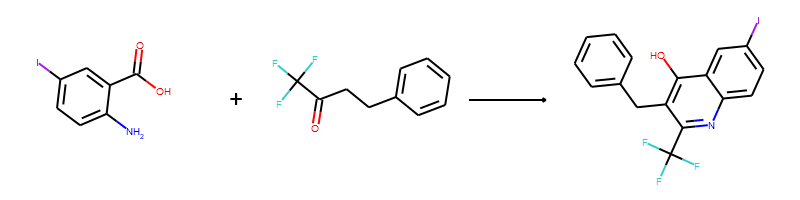

########## RetroSim Top-1 prediction (Rank 9999) ##########


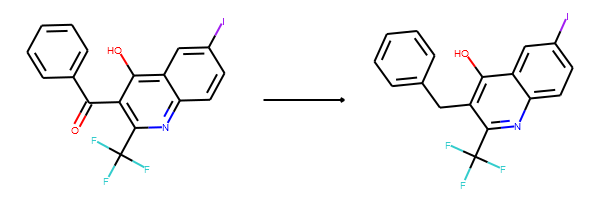

########## GLN Top-1 prediction (Rank 9999) ##########


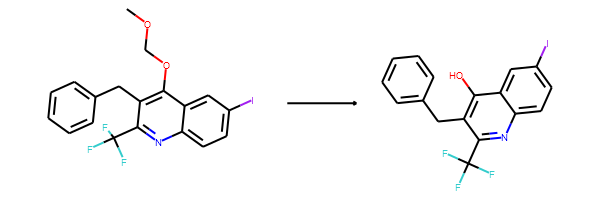

########## Xpert Top-1 prediction (Rank 9999) ##########


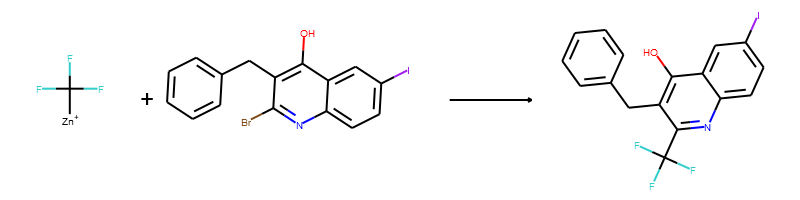

In [67]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[0]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
sim_rank = top10plus.iloc[row_idx]['sim_rank']
GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

#################### Reaction Class 4 ####################
########## Original reaction ##########


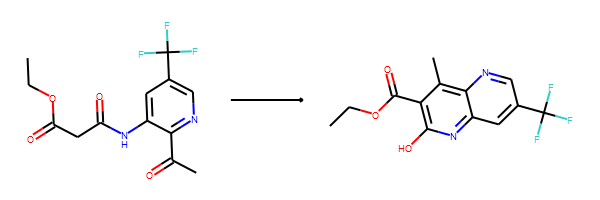

########## RetroSim Top-1 prediction (Rank 9999) ##########


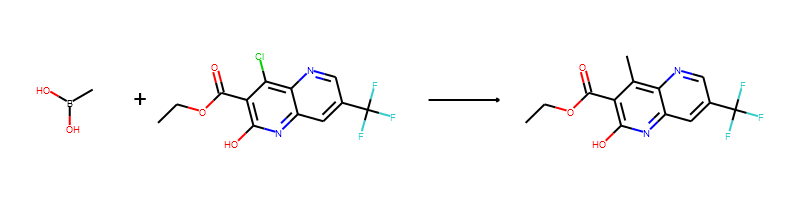

########## GLN Top-1 prediction (Rank 9999) ##########


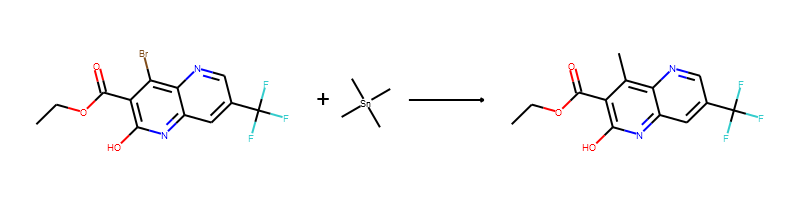

########## Xpert Top-1 prediction (Rank 9999) ##########


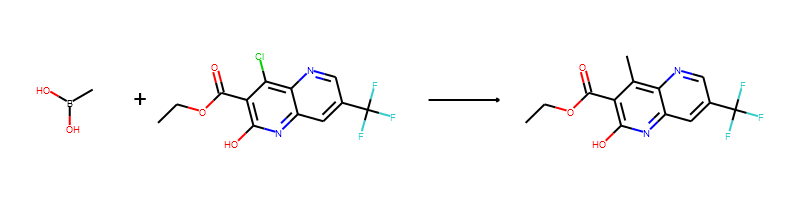

In [68]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[1]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
sim_rank = top10plus.iloc[row_idx]['sim_rank']
GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

#################### Reaction Class 4 ####################
########## Original reaction ##########


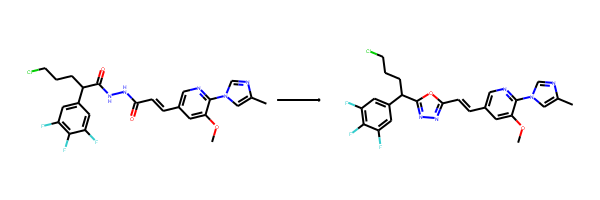

########## RetroSim Top-1 prediction (Rank 21) ##########


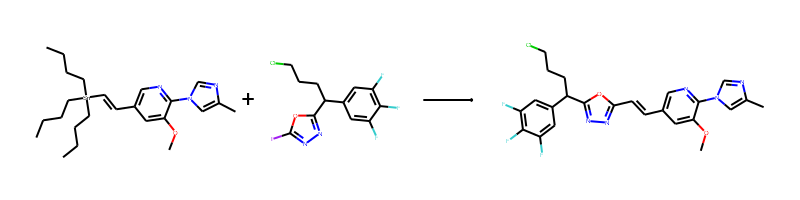

########## GLN Top-1 prediction (Rank 9999) ##########


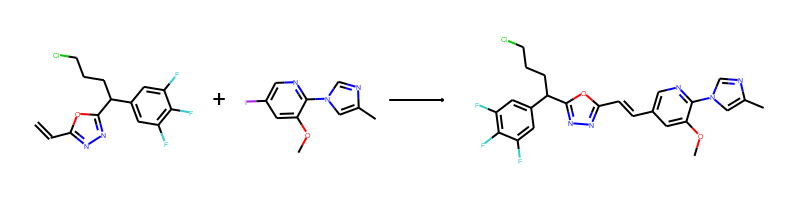

########## Xpert Top-1 prediction (Rank 9999) ##########


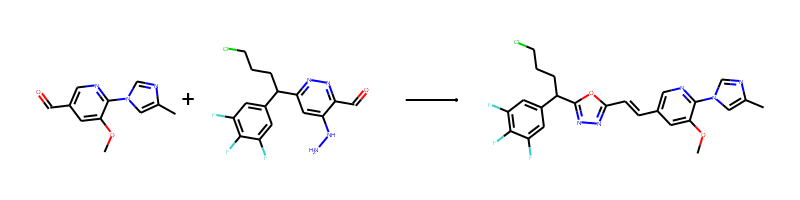

In [70]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[2]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
sim_rank = top10plus.iloc[row_idx]['sim_rank']
GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

### rxn_type = 3 across all 3 proposers

In [89]:
rxn_type = 3
gln_props = gln_props_df.fillna('9999')
gln_props = gln_props[gln_props.rxn_type == str(rxn_type)]
retrosim_props = retrosim_props_df.fillna('9999')
retrosim_props = retrosim_props[retrosim_props.rxn_type == str(rxn_type)]
retroxpert_props = retroxpert_props_df.fillna('9999')
retroxpert_props = retroxpert_props[retroxpert_props.rxn_type == str(rxn_type)]

# take top-5 predictions for visualization/comparison
combined = pd.concat([retrosim_props.iloc[:, 0:10], gln_props.iloc[:, 4:10], retroxpert_props.iloc[:, 4:10]], 
                     axis=1)

sim_cnt = 5
gln_cnt = 5
new_cols = []
for i, col in enumerate(combined.columns):
    if sim_cnt > 0 and 'cand_precursor' in col:
        new_col = 'sim_' + col[:4] + '_' + col[-1]
        sim_cnt -= 1
    elif sim_cnt > 0 and 'rank' in col:
        new_col = 'sim_rank'
    elif gln_cnt > 0 and 'cand_precursor' in col:
        new_col = 'GLN_' + col[:4] + '_' + col[-1]
        gln_cnt -= 1
    elif gln_cnt > 0 and 'rank' in col:
        new_col = 'GLN_rank'
    elif 'cand_precursor' in col:
        new_col = 'Xpert_' + col[:4] + '_' + col[-1]
    elif 'rank' in col:
        new_col  = 'Xpert_rank'
    else:
        new_col = col
    new_cols.append(new_col)
combined.columns = new_cols

In [72]:
top10plus = combined[combined.sim_rank.astype('int') < 5] # RetroSim rank 0 to 4
top10plus = top10plus[top10plus.GLN_rank.astype('int') > 4] # GLN rank 5 or worse
# total ~8% of 567 = 46 rxn_smi
top10plus.shape

(46, 22)

### visualize 3 random rxn_smi when RetroSim rank < 5 but GLN rank >= 5

#################### Reaction Class 3 ####################
########## Original reaction ##########


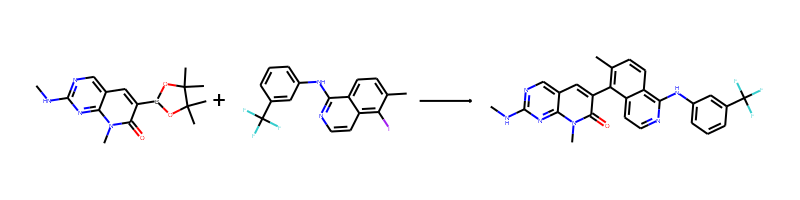

########## RetroSim Top-1 prediction (Rank 0) ##########


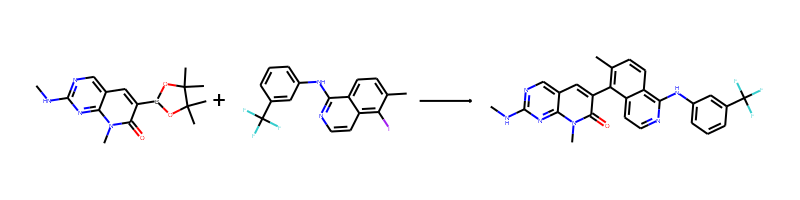

########## GLN Top-1 prediction (Rank 6) ##########


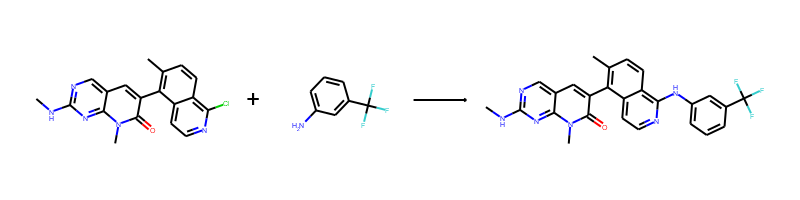

In [73]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[0]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
# Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
sim_rank = top10plus.iloc[row_idx]['sim_rank']
GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
# Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

# Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
# print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
# image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
# display(image)

#################### Reaction Class 3 ####################
########## Original reaction ##########


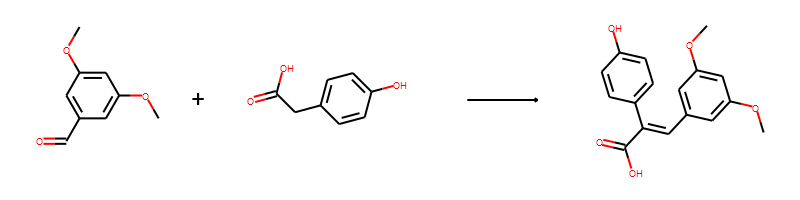

########## RetroSim Top-1 prediction (Rank 2) ##########


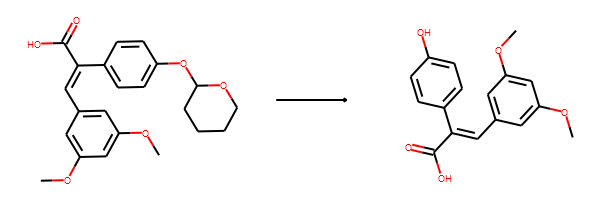

########## GLN Top-1 prediction (Rank 9999) ##########


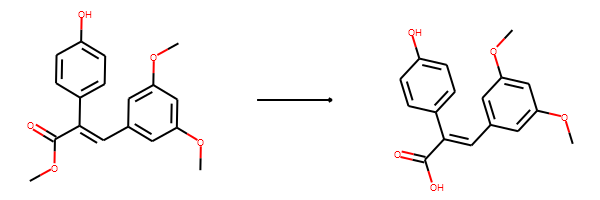

In [74]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[1]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
# Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
sim_rank = top10plus.iloc[row_idx]['sim_rank']
GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
# Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

# Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
# print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
# image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
# display(image)

#################### Reaction Class 3 ####################
########## Original reaction ##########


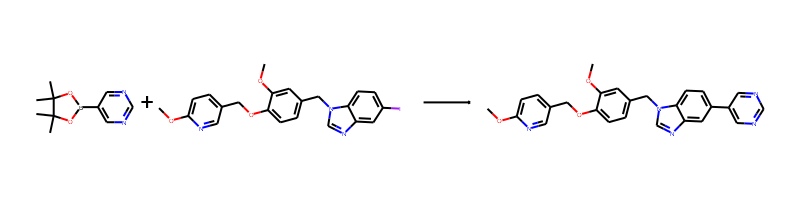

########## RetroSim Top-1 prediction (Rank 0) ##########


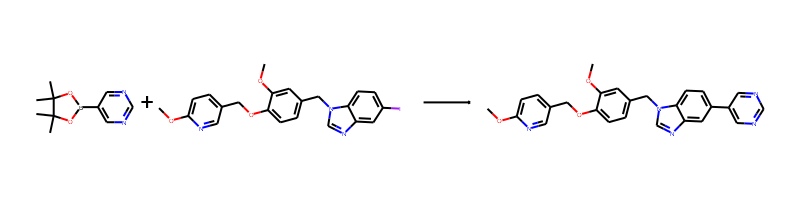

########## GLN Top-1 prediction (Rank 9) ##########


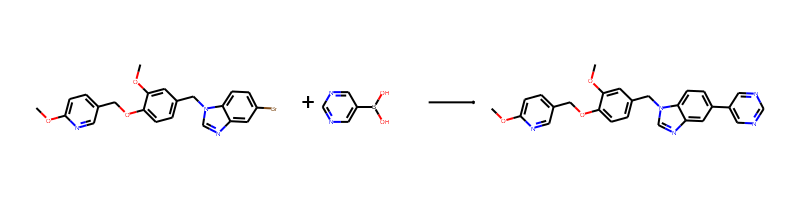

In [75]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[2]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
# Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
sim_rank = top10plus.iloc[row_idx]['sim_rank']
GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
# Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

# Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
# print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
# image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
# display(image)

### visualize 3 random rxn_smi when GLN rank < 5 but RetroXpert rank >= 10

In [90]:
top10plus = combined[combined.GLN_rank.astype('int') < 5] # GLN rank < 5
top10plus = top10plus[top10plus.Xpert_rank.astype('int') >= 10] # RetroXpert rank 10 or worse
# total ~10.4% of 567 = 59 rxn_smi
top10plus.shape

(59, 22)

#################### Reaction Class 3 ####################
########## Original reaction ##########


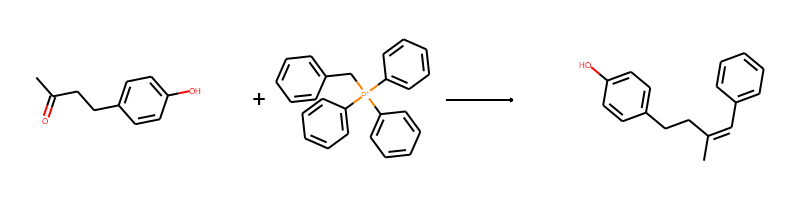

########## GLN Top-1 prediction (Rank 1) ##########


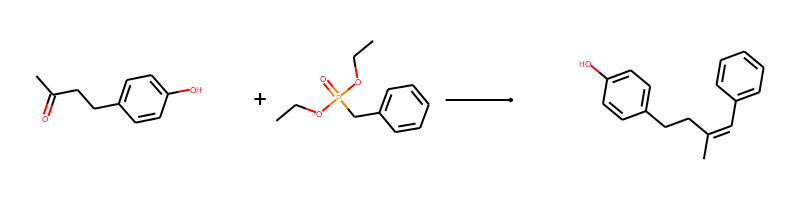

########## Xpert Top-1 prediction (Rank 9999) ##########


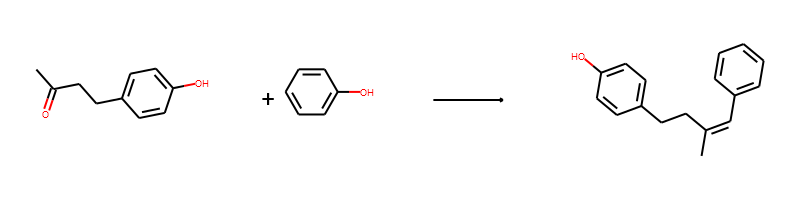

In [91]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[0]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
# sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
# sim_rank = top10plus.iloc[row_idx]['sim_rank']
GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

# sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
# print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
# image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
# display(image)

GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

#################### Reaction Class 3 ####################
########## Original reaction ##########


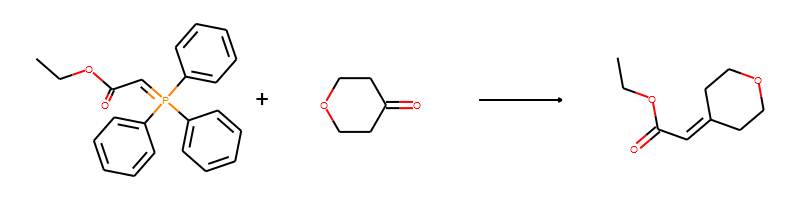

########## GLN Top-1 prediction (Rank 1) ##########


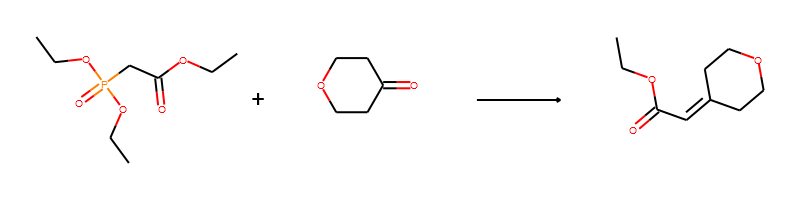

########## Xpert Top-1 prediction (Rank 15) ##########


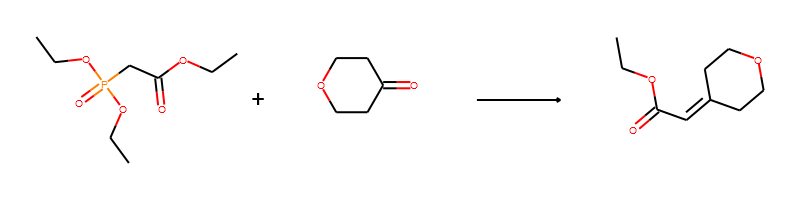

In [92]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[1]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
# sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
# sim_rank = top10plus.iloc[row_idx]['sim_rank']
GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

# sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
# print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
# image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
# display(image)

GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

#################### Reaction Class 3 ####################
########## Original reaction ##########


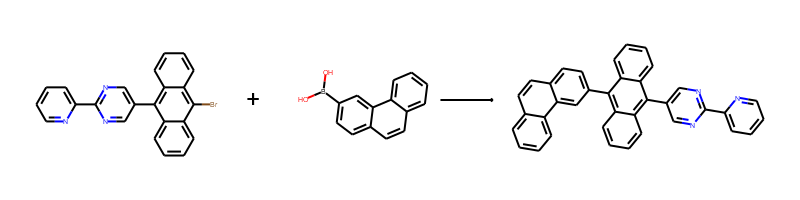

########## GLN Top-1 prediction (Rank 1) ##########


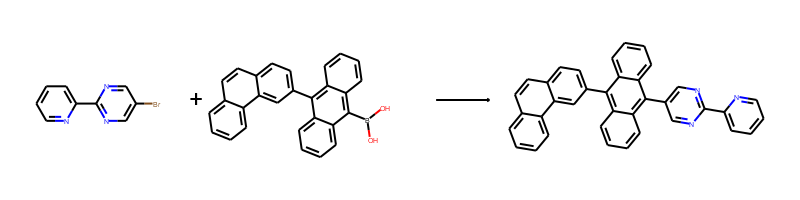

########## Xpert Top-1 prediction (Rank 11) ##########


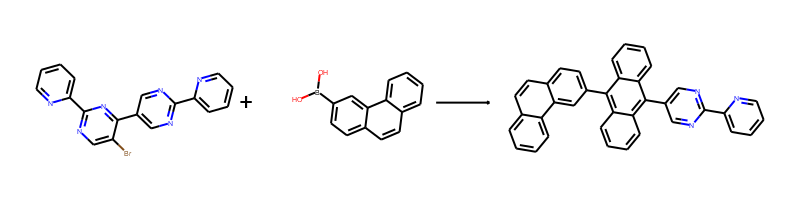

In [93]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[2]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
# sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
# sim_rank = top10plus.iloc[row_idx]['sim_rank']
GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

# sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
# print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
# image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
# display(image)

GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

### rxn_type = 5 (RetroXpert particularly bad here)

In [77]:
rxn_type = 5
gln_props = gln_props_df.fillna('9999')
gln_props = gln_props[gln_props.rxn_type == str(rxn_type)]
retrosim_props = retrosim_props_df.fillna('9999')
retrosim_props = retrosim_props[retrosim_props.rxn_type == str(rxn_type)]
retroxpert_props = retroxpert_props_df.fillna('9999')
retroxpert_props = retroxpert_props[retroxpert_props.rxn_type == str(rxn_type)]

# take top-5 predictions for visualization/comparison
combined = pd.concat([retrosim_props.iloc[:, 0:10], gln_props.iloc[:, 4:10], retroxpert_props.iloc[:, 4:10]], 
                     axis=1)

sim_cnt = 5
gln_cnt = 5
new_cols = []
for i, col in enumerate(combined.columns):
    if sim_cnt > 0 and 'cand_precursor' in col:
        new_col = 'sim_' + col[:4] + '_' + col[-1]
        sim_cnt -= 1
    elif sim_cnt > 0 and 'rank' in col:
        new_col = 'sim_rank'
    elif gln_cnt > 0 and 'cand_precursor' in col:
        new_col = 'GLN_' + col[:4] + '_' + col[-1]
        gln_cnt -= 1
    elif gln_cnt > 0 and 'rank' in col:
        new_col = 'GLN_rank'
    elif 'cand_precursor' in col:
        new_col = 'Xpert_' + col[:4] + '_' + col[-1]
    elif 'rank' in col:
        new_col  = 'Xpert_rank'
    else:
        new_col = col
    new_cols.append(new_col)
combined.columns = new_cols

top10plus = combined[combined.sim_rank.astype('int') < 5] # RetroSim rank 0 to 4
top10plus = top10plus[top10plus.Xpert_rank.astype('int') >= 10] # RetroXpert rank 10 or worse
# total ~19% of 68 = 13 rxn_smi
top10plus.shape

(13, 22)

### visualize 3 random rxn_smi when RetroSim rank < 5 but RetroXpert rank >= 10
- RetroXpert seems to favor this particular trifluoromethylating agent (which is not original reaction)

#################### Reaction Class 5 ####################
########## Original reaction ##########


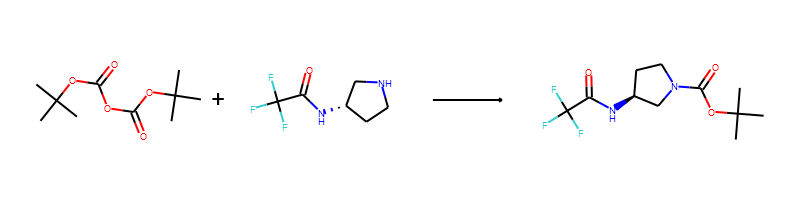

########## RetroSim Top-1 prediction (Rank 4) ##########


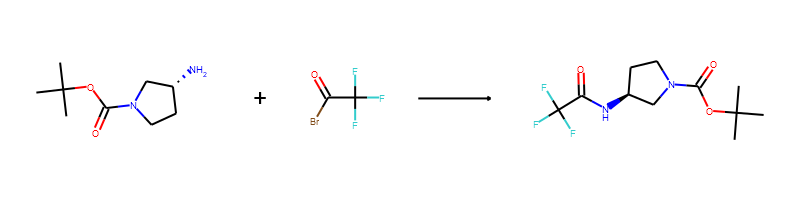

########## Xpert Top-1 prediction (Rank 56) ##########


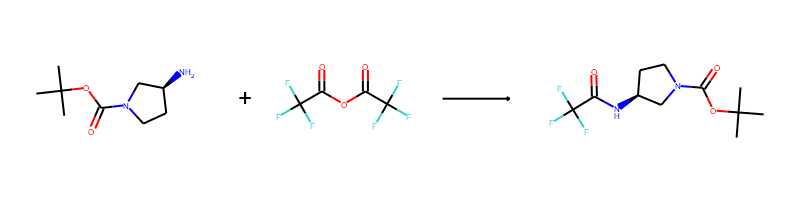

In [78]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[0]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
# GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
sim_rank = top10plus.iloc[row_idx]['sim_rank']
# GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

# GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
# print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
# image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
# display(image)

Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

#################### Reaction Class 5 ####################
########## Original reaction ##########


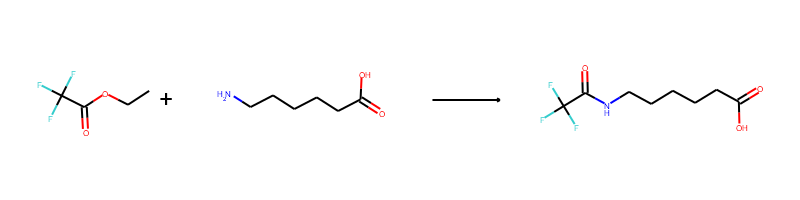

########## RetroSim Top-1 prediction (Rank 1) ##########


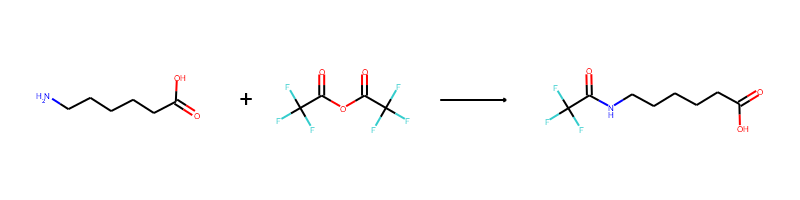

########## Xpert Top-1 prediction (Rank 30) ##########


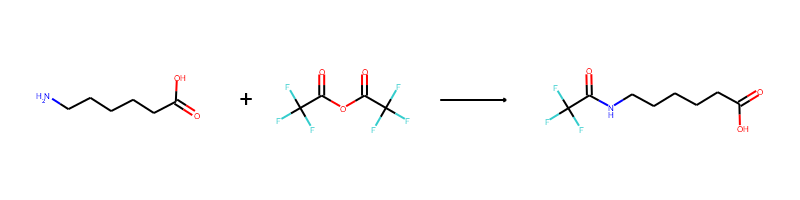

In [79]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[1]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
# GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
sim_rank = top10plus.iloc[row_idx]['sim_rank']
# GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

# GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
# print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
# image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
# display(image)

Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

#################### Reaction Class 5 ####################
########## Original reaction ##########


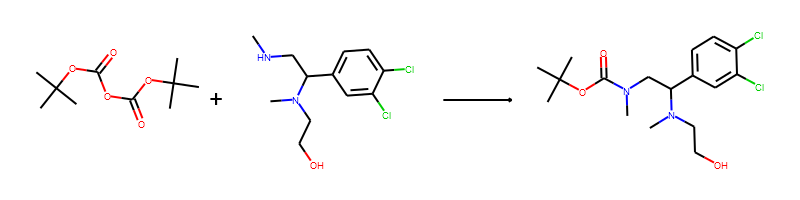

########## RetroSim Top-1 prediction (Rank 3) ##########


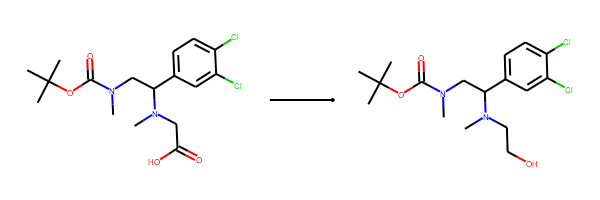

########## Xpert Top-1 prediction (Rank 9999) ##########


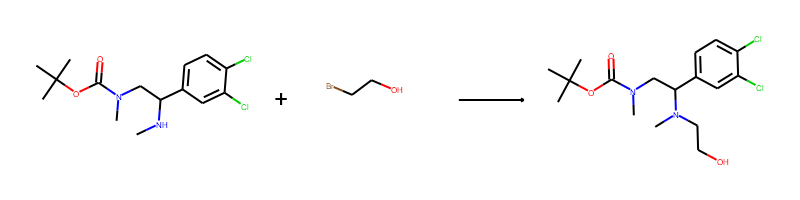

In [80]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[2]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
# GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
sim_rank = top10plus.iloc[row_idx]['sim_rank']
# GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

# GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
# print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
# image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
# display(image)

Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

### rxn_type = 9 (large 26% that both GLN & RetroSim get >= rank 10)

In [81]:
rxn_type = 9
gln_props = gln_props_df.fillna('9999')
gln_props = gln_props[gln_props.rxn_type == str(rxn_type)]
retrosim_props = retrosim_props_df.fillna('9999')
retrosim_props = retrosim_props[retrosim_props.rxn_type == str(rxn_type)]
retroxpert_props = retroxpert_props_df.fillna('9999')
retroxpert_props = retroxpert_props[retroxpert_props.rxn_type == str(rxn_type)]

# take top-5 predictions for visualization/comparison
combined = pd.concat([retrosim_props.iloc[:, 0:10], gln_props.iloc[:, 4:10], retroxpert_props.iloc[:, 4:10]], 
                     axis=1)

sim_cnt = 5
gln_cnt = 5
new_cols = []
for i, col in enumerate(combined.columns):
    if sim_cnt > 0 and 'cand_precursor' in col:
        new_col = 'sim_' + col[:4] + '_' + col[-1]
        sim_cnt -= 1
    elif sim_cnt > 0 and 'rank' in col:
        new_col = 'sim_rank'
    elif gln_cnt > 0 and 'cand_precursor' in col:
        new_col = 'GLN_' + col[:4] + '_' + col[-1]
        gln_cnt -= 1
    elif gln_cnt > 0 and 'rank' in col:
        new_col = 'GLN_rank'
    elif 'cand_precursor' in col:
        new_col = 'Xpert_' + col[:4] + '_' + col[-1]
    elif 'rank' in col:
        new_col  = 'Xpert_rank'
    else:
        new_col = col
    new_cols.append(new_col)
combined.columns = new_cols

top10plus = combined[combined.sim_rank.astype('int') >= 10] # RetroSim rank 10 or worse
top10plus = top10plus[top10plus.GLN_rank.astype('int') >= 10] # GLN rank 10 or worse
# total ~26% of 183 = 48 rxn_smi
top10plus.shape

(48, 22)

### visualized 3 random rxn_smi when both GLN & RetroSim rank >= 10

#################### Reaction Class 9 ####################
########## Original reaction ##########


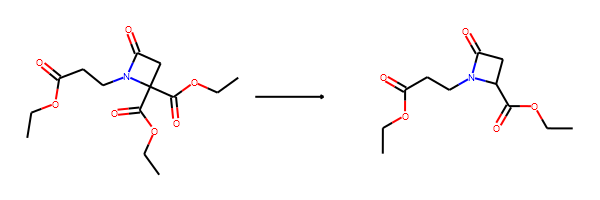

########## RetroSim Top-1 prediction (Rank 9999) ##########


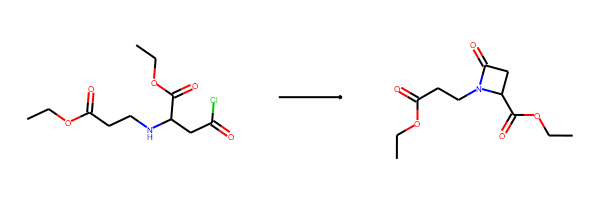

########## GLN Top-1 prediction (Rank 9999) ##########


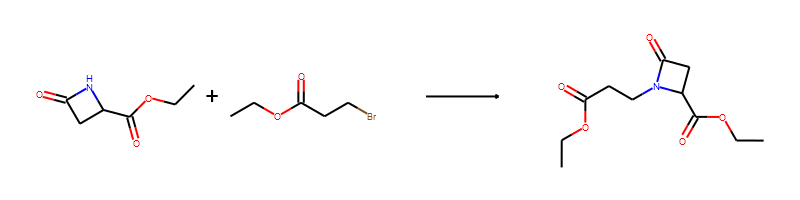

In [85]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[0]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
# Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
sim_rank = top10plus.iloc[row_idx]['sim_rank']
GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
# Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

# Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
# print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
# image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
# display(image)

#################### Reaction Class 9 ####################
########## Original reaction ##########


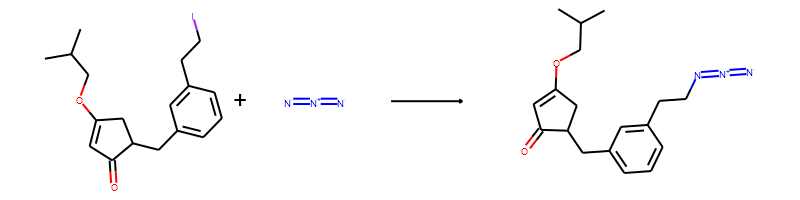

########## RetroSim Top-1 prediction (Rank 9999) ##########


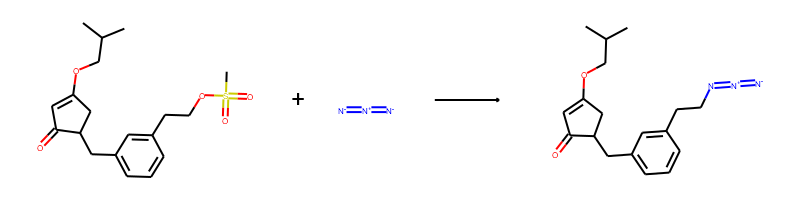

########## GLN Top-1 prediction (Rank 9999) ##########


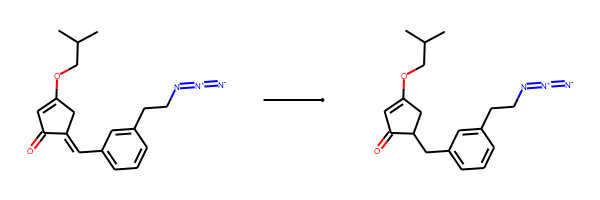

In [86]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[1]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
# Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
sim_rank = top10plus.iloc[row_idx]['sim_rank']
GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
# Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

# Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
# print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
# image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
# display(image)

- GLN seems to not like putting N3- as reagent in SN2, but rather already part of reactant molecule
- RetroSim did identify that correctly, but used wrong LG (sulfonate)

#################### Reaction Class 9 ####################
########## Original reaction ##########


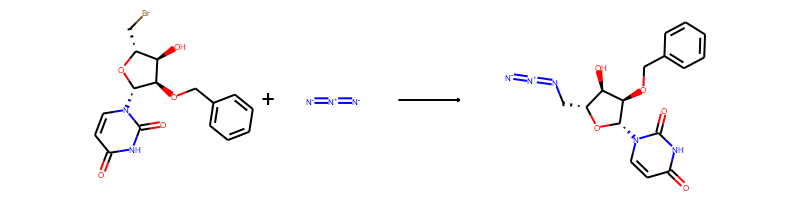

########## RetroSim Top-1 prediction (Rank 10) ##########


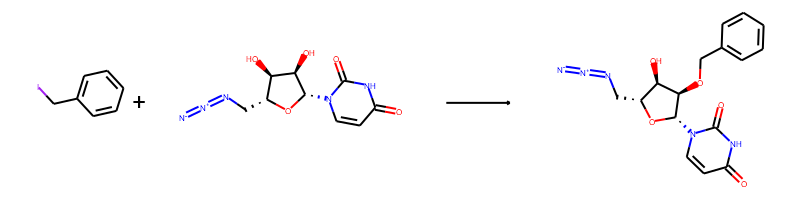

########## GLN Top-1 prediction (Rank 9999) ##########


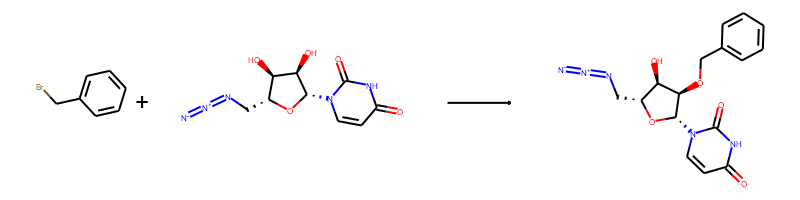

In [87]:
row_idx = top10plus.reset_index(drop=True).sample(3, random_state=1337).index[2]

prod_smi = top10plus.iloc[row_idx]['prod_smi']
true_precursor = top10plus.iloc[row_idx]['true_precursors']

prec_rank = 1
sim_prec = top10plus.iloc[row_idx][f'sim_cand_{prec_rank}']
GLN_prec = top10plus.iloc[row_idx][f'GLN_cand_{prec_rank}']
# Xpert_prec = top10plus.iloc[row_idx][f'Xpert_cand_{prec_rank}']
sim_rank = top10plus.iloc[row_idx]['sim_rank']
GLN_rank = top10plus.iloc[row_idx]['GLN_rank']
# Xpert_rank = top10plus.iloc[row_idx]['Xpert_rank']

print('#'*20, f'Reaction Class {rxn_type}', '#'*20)

true_rxn_smi = true_precursor + '>>' + prod_smi
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(true_rxn_smi, useSmiles=True), (200,200))
print('#'*10, 'Original reaction', '#'*10)
display(image)

sim_pred_rxn_smi = sim_prec + '>>' + prod_smi
print('#'*10, f'RetroSim Top-{prec_rank} prediction (Rank {sim_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sim_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

GLN_pred_rxn_smi = GLN_prec + '>>' + prod_smi
print('#'*10, f'GLN Top-{prec_rank} prediction (Rank {GLN_rank})', '#'*10)
image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(GLN_pred_rxn_smi, useSmiles=True), (200,200))
display(image)

# Xpert_pred_rxn_smi = Xpert_prec + '>>' + prod_smi
# print('#'*10, f'Xpert Top-{prec_rank} prediction (Rank {Xpert_rank})', '#'*10)
# image = Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(Xpert_pred_rxn_smi, useSmiles=True), (200,200))
# display(image)

- same as above, GLN doesnt like using N3- as attacking group
- RetroSim v similar to GLN, just different LG (I vs Br)

### placeholder

## matrix compare w/in rxn_type

### GLN vs RetroSim, top-1 vs 2-10 vs 11+

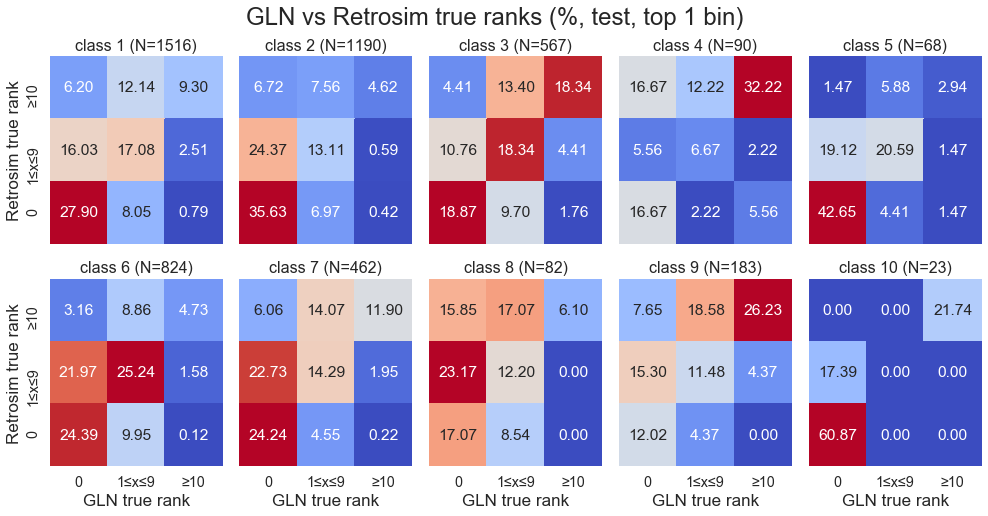

In [11]:
phase = 'test'

gln_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_retrain_200topk_200maxk_noGT_typed_{phase}.csv', 
                        index_col=None, dtype='str')
retrosim_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200topk_200maxk_noGT_typed_{phase}.csv', 
                             index_col=None, dtype='str')

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axs = axs.flatten()
fig.suptitle(f'GLN vs Retrosim true ranks (%, {phase}, top 1 bin)', fontsize=24, y=1.03)

for rxn_type in range(1, 11):
    gln_props = gln_props_df.fillna('9999')
    gln_props = gln_props[gln_props.rxn_type == str(rxn_type)]
    gln_props_np = gln_props.values

    retrosim_props = retrosim_props_df.fillna('9999')
    retrosim_props = retrosim_props[retrosim_props.rxn_type == str(rxn_type)]
    retrosim_props_np = retrosim_props.values 

    ranks_combined = pd.concat([retrosim_props.rank_of_true_precursor, gln_props.rank_of_true_precursor], axis=1)
    ranks_combined.columns = ['retrosim_true_rank', 'gln_true_rank']
    ranks_combined = ranks_combined.astype('int')

    rank_matrix = np.zeros((3, 3), dtype='int32') # row = retrosim, col = retroxpert
    for row_idx in range(ranks_combined.shape[0]):
        retrosim_true_rank = ranks_combined.iloc[row_idx, 0]
        gln_true_rank = ranks_combined.iloc[row_idx, 1]
        if 9 >= retrosim_true_rank >= 1:
            row = 1
        elif retrosim_true_rank > 9:
            row = 2
        else:
            row = retrosim_true_rank
        if 9 >= gln_true_rank >= 1:
            col = 1
        elif gln_true_rank > 9:
            col = 2
        else:
            col = gln_true_rank
        rank_matrix[row, col] += 1

    sns.set(font_scale=1.3)
#     f, ax = plt.subplots(figsize=(3,3))
#     ax = axs[rxn_type-1
    sns.heatmap(
        data=np.flip(rank_matrix / ranks_combined.shape[0] * 100, axis=0),
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        cbar=False,
        ax=axs[rxn_type-1]
    );
    
    axs[rxn_type-1].set_title(f'class {rxn_type} (N={ranks_combined.shape[0]})', fontsize=16);
    axs[rxn_type-1].set_xticklabels(['0', '1≤x≤9', '≥10']);
    if rxn_type-1 >= 5:
        axs[rxn_type-1].set_xlabel('GLN true rank', fontsize=17);
    axs[rxn_type-1].set_yticklabels(reversed(['0', '1≤x≤9', '≥10']));
    if rxn_type-1 == 0 or rxn_type-1 == 5:
        axs[rxn_type-1].set_ylabel('Retrosim true rank', fontsize=17);

# doesnt work, to add big x & big y label to whole of subplot
# add a big axis, hide frame
# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axis
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.xlabel("GLN true rank", fontsize=14.5)
# plt.ylabel("Retrosim true rank", fontsize=14.5)

plt.tight_layout()
plt.savefig(f'rxnebm/analysis/GLN_vs_retrosim_rank_matrix_typed_{phase}.png', bbox_inches = 'tight')

### GLN vs retrosim, top-1-5 vs 6-10 vs 11+

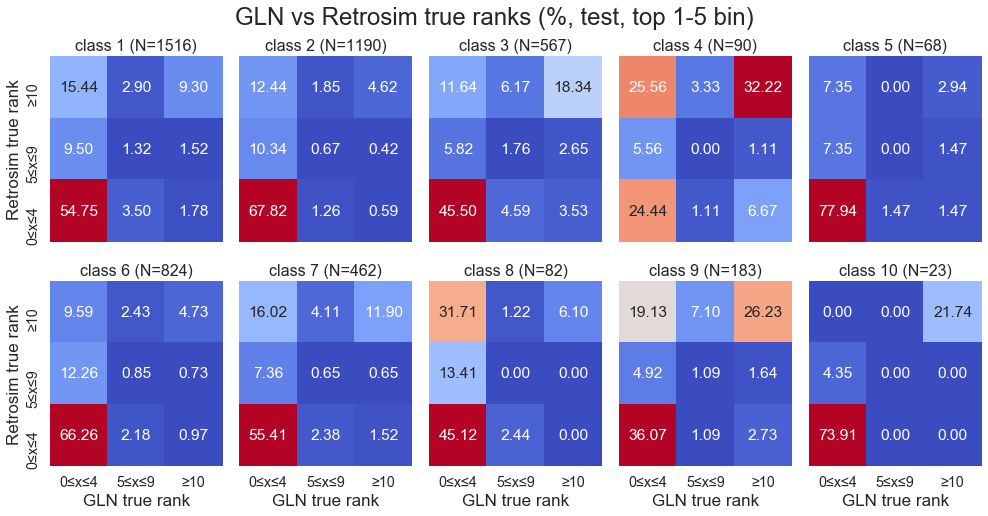

In [10]:
phase = 'test'

gln_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_retrain_200topk_200maxk_noGT_typed_{phase}.csv', 
                        index_col=None, dtype='str')
retrosim_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200topk_200maxk_noGT_typed_{phase}.csv', 
                             index_col=None, dtype='str')

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axs = axs.flatten()
fig.suptitle(f'GLN vs Retrosim true ranks (%, {phase}, top 1-5 bin)', fontsize=24, y=1.03)

for rxn_type in range(1, 11):
    gln_props = gln_props_df.fillna('9999')
    gln_props = gln_props[gln_props.rxn_type == str(rxn_type)]
    gln_props_np = gln_props.values

    retrosim_props = retrosim_props_df.fillna('9999')
    retrosim_props = retrosim_props[retrosim_props.rxn_type == str(rxn_type)]
    retrosim_props_np = retrosim_props.values

    ranks_combined = pd.concat([retrosim_props.rank_of_true_precursor, gln_props.rank_of_true_precursor], axis=1)
    ranks_combined.columns = ['retrosim_true_rank', 'gln_true_rank']
    ranks_combined = ranks_combined.astype('int')

    rank_matrix = np.zeros((3, 3), dtype='int32') # row = retrosim, col = retroxpert
    for row_idx in range(ranks_combined.shape[0]):
        retrosim_true_rank = ranks_combined.iloc[row_idx, 0]
        gln_true_rank = ranks_combined.iloc[row_idx, 1]
        if 9 >= retrosim_true_rank >= 5:
            row = 1
        elif retrosim_true_rank > 9:
            row = 2
        else: # rank-0 to rank-4
            row = 0
        if 9 >= gln_true_rank >= 5:
            col = 1
        elif gln_true_rank > 9:
            col = 2
        else: # rank-0 to rank-4
            col = 0
        rank_matrix[row, col] += 1

    sns.set(font_scale=1.3)
#     f, ax = plt.subplots(figsize=(3,3))
#     ax = axs[rxn_type-1
    sns.heatmap(
        data=np.flip(rank_matrix / ranks_combined.shape[0] * 100, axis=0),
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        cbar=False,
        ax=axs[rxn_type-1]
    );
    
    axs[rxn_type-1].set_title(f'class {rxn_type} (N={ranks_combined.shape[0]})', fontsize=16);
    axs[rxn_type-1].set_xticklabels(['0≤x≤4', '5≤x≤9', '≥10']);
    if rxn_type-1 >= 5:
        axs[rxn_type-1].set_xlabel('GLN true rank', fontsize=17);
    axs[rxn_type-1].set_yticklabels(reversed(['0≤x≤4', '5≤x≤9', '≥10']));
    if rxn_type-1 == 0 or rxn_type-1 == 5:
        axs[rxn_type-1].set_ylabel('Retrosim true rank', fontsize=17);

plt.tight_layout()
plt.savefig(f'rxnebm/analysis/GLN_vs_retrosim_rank_matrix_typed_top1to5_{phase}.png', bbox_inches = 'tight')

- Class 4 is the worst for both GLN & RetroSim, followed by 9, 3 and 8 <br><br>
**Interesting observations:**
- Still room for GLN to improve in class 3 relative to other classes, since there's ~8% total that RetroSim gets in rank 0-4 but GLN worse than rank 4
- And of course class 4, but RetroSim does very badly too

### GLN vs Retroxpert, top-1 vs 2-10 vs 11+

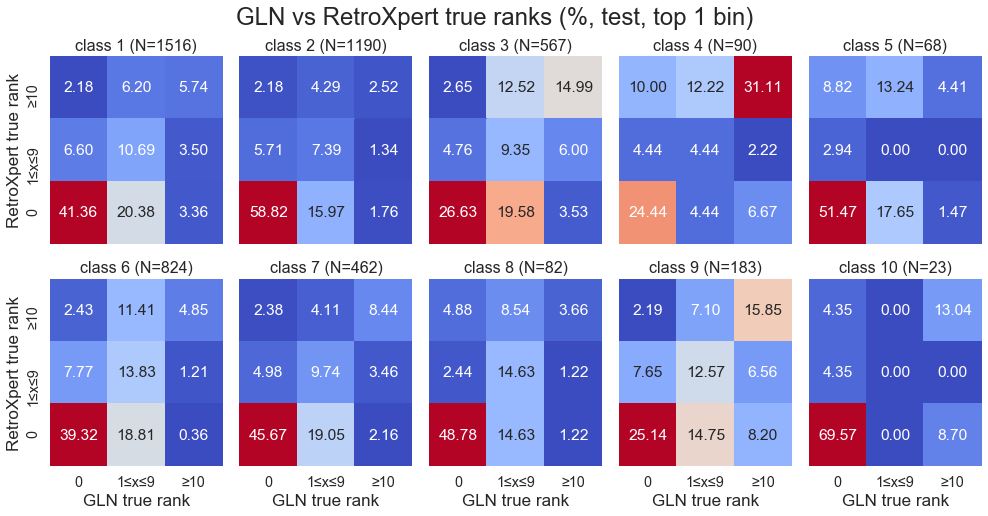

In [9]:
phase = 'test'

gln_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_retrain_200topk_200maxk_noGT_typed_{phase}.csv', 
                        index_col=None, dtype='str')
retroxpert_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_noGT_typed_{phase}.csv', 
                             index_col=None, dtype='str')

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axs = axs.flatten()
fig.suptitle(f'GLN vs RetroXpert true ranks (%, {phase}, top 1 bin)', fontsize=24, y=1.03)
for rxn_type in range(1, 11):
    gln_props = gln_props_df.fillna('9999')
    gln_props = gln_props[gln_props.rxn_type == str(rxn_type)]
    gln_props_np = gln_props.values

    retroxpert_props = retroxpert_props_df.fillna('9999')
    retroxpert_props = retroxpert_props[retroxpert_props.rxn_type == str(rxn_type)]
    retroxpert_props_np = retroxpert_props.values 

    ranks_combined = pd.concat([retroxpert_props.rank_of_true_precursor, gln_props.rank_of_true_precursor], axis=1)
    ranks_combined.columns = ['retroxpert_true_rank', 'gln_true_rank']
    ranks_combined = ranks_combined.astype('int')

    rank_matrix = np.zeros((3, 3), dtype='int32') # row = retrosim, col = retroxpert
    for row_idx in range(ranks_combined.shape[0]):
        retroxpert_true_rank = ranks_combined.iloc[row_idx, 0]
        gln_true_rank = ranks_combined.iloc[row_idx, 1]
        if 9 >= retroxpert_true_rank >= 1:
            row = 1
        elif retroxpert_true_rank > 9:
            row = 2
        else:
            row = retroxpert_true_rank
        if 9>= gln_true_rank >= 1:
            col = 1
        elif gln_true_rank > 9:
            col = 2
        else:
            col = gln_true_rank
        rank_matrix[row, col] += 1

    sns.set(font_scale=1.3)
#     f, ax = plt.subplots(figsize=(3,3))
#     ax = axs[rxn_type-1
    sns.heatmap(
        data=np.flip(rank_matrix / ranks_combined.shape[0] * 100, axis=0),
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        cbar=False,
        ax=axs[rxn_type-1]
    );
    
    axs[rxn_type-1].set_title(f'class {rxn_type} (N={ranks_combined.shape[0]})', fontsize=16);
    axs[rxn_type-1].set_xticklabels(['0', '1≤x≤9', '≥10']);
    if rxn_type-1 >= 5:
        axs[rxn_type-1].set_xlabel('GLN true rank', fontsize=17);
    axs[rxn_type-1].set_yticklabels(reversed(['0', '1≤x≤9', '≥10']));
    if rxn_type-1 == 0 or rxn_type-1 == 5:
        axs[rxn_type-1].set_ylabel('RetroXpert true rank', fontsize=17);

plt.tight_layout()
plt.savefig(f'rxnebm/analysis/GLN_vs_retroxpert_rank_matrix_typed_{phase}.png', bbox_inches = 'tight')

### GLN vs Retroxpert, top-1-5 vs 6-10 vs 11+

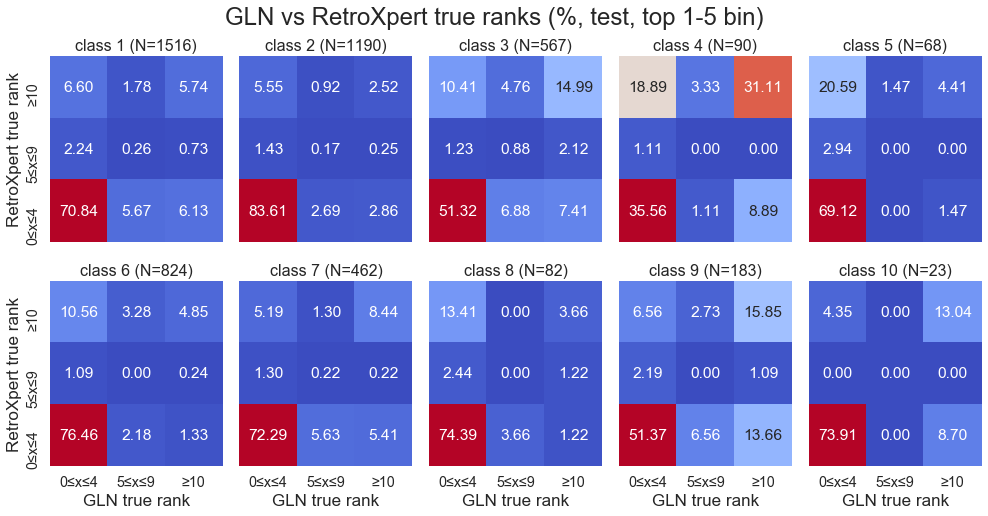

In [8]:
phase = 'test'

gln_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_retrain_200topk_200maxk_noGT_typed_{phase}.csv', 
                        index_col=None, dtype='str')
retroxpert_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_noGT_typed_{phase}.csv', 
                             index_col=None, dtype='str')

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axs = axs.flatten()
fig.suptitle(f'GLN vs RetroXpert true ranks (%, {phase}, top 1-5 bin)', fontsize=24, y=1.03)
for rxn_type in range(1, 11):
    gln_props = gln_props_df.fillna('9999')
    gln_props = gln_props[gln_props.rxn_type == str(rxn_type)]
    gln_props_np = gln_props.values

    retroxpert_props = retroxpert_props_df.fillna('9999')
    retroxpert_props = retroxpert_props[retroxpert_props.rxn_type == str(rxn_type)]
    retroxpert_props_np = retroxpert_props.values 

    ranks_combined = pd.concat([retroxpert_props.rank_of_true_precursor, gln_props.rank_of_true_precursor], axis=1)
    ranks_combined.columns = ['retroxpert_true_rank', 'gln_true_rank']
    ranks_combined = ranks_combined.astype('int')

    rank_matrix = np.zeros((3, 3), dtype='int32') # row = retrosim, col = retroxpert
    for row_idx in range(ranks_combined.shape[0]):
        retroxpert_true_rank = ranks_combined.iloc[row_idx, 0]
        gln_true_rank = ranks_combined.iloc[row_idx, 1]
        if 9 >= retroxpert_true_rank >= 5:
            row = 1
        elif retroxpert_true_rank > 9:
            row = 2
        else:
            row = 0
        if 9 >= gln_true_rank >= 5:
            col = 1
        elif gln_true_rank > 9:
            col = 2
        else:
            col = 0
        rank_matrix[row, col] += 1

    sns.set(font_scale=1.3)
#     f, ax = plt.subplots(figsize=(3,3))
#     ax = axs[rxn_type-1
    sns.heatmap(
        data=np.flip(rank_matrix / ranks_combined.shape[0] * 100, axis=0),
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        cbar=False,
        ax=axs[rxn_type-1]
    );
    
    axs[rxn_type-1].set_title(f'class {rxn_type} (N={ranks_combined.shape[0]})', fontsize=16);
    axs[rxn_type-1].set_xticklabels(['0≤x≤4', '5≤x≤9', '≥10']);
    if rxn_type-1 >= 5:
        axs[rxn_type-1].set_xlabel('GLN true rank', fontsize=17);
    axs[rxn_type-1].set_yticklabels(reversed(['0≤x≤4', '5≤x≤9', '≥10']));
    if rxn_type-1 == 0 or rxn_type-1 == 5:
        axs[rxn_type-1].set_ylabel('RetroXpert true rank', fontsize=17);

plt.tight_layout()
plt.savefig(f'rxnebm/analysis/GLN_vs_retroxpert_rank_matrix_typed_top1to5_{phase}.png', bbox_inches = 'tight')

- Class 4 is the worst for both GLN & RetroSim, followed by 9, 3 and 8 (using % in bottomleft-most box)
- Class 4 is the worst for both GLN & RetroXpert, followed by 9, 3 and 8 (using % in bottomleft-most box)

### Retrosim vs Retroxpert, top-1 vs 2-10 vs 11+

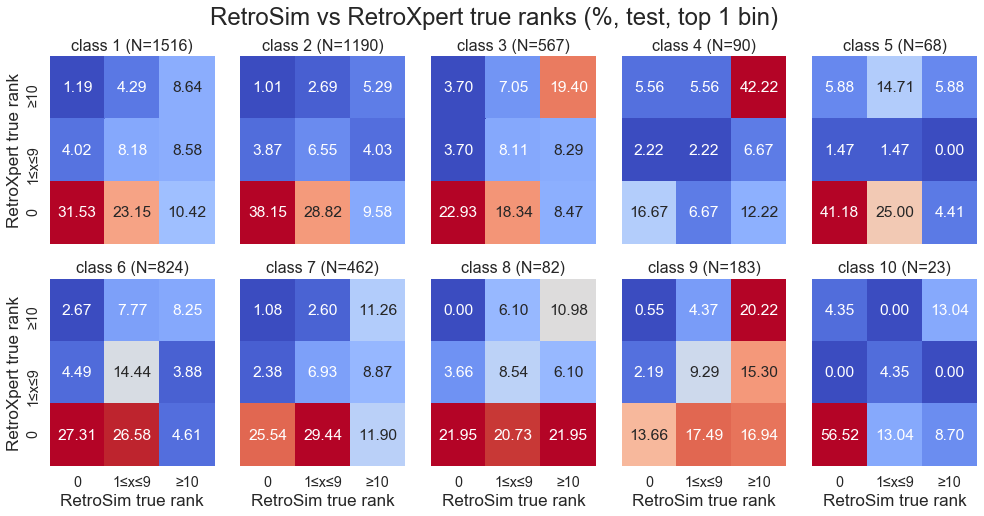

In [12]:
phase = 'test'

retrosim_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200topk_200maxk_noGT_typed_{phase}.csv', 
                        index_col=None, dtype='str')
retroxpert_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_noGT_typed_{phase}.csv', 
                             index_col=None, dtype='str')

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axs = axs.flatten()
fig.suptitle(f'RetroSim vs RetroXpert true ranks (%, {phase}, top 1 bin)', fontsize=24, y=1.03)
for rxn_type in range(1, 11):
    retrosim_props = retrosim_props_df.fillna('9999')
    retrosim_props = retrosim_props[retrosim_props.rxn_type == str(rxn_type)]
    
    retroxpert_props = retroxpert_props_df.fillna('9999')
    retroxpert_props = retroxpert_props[retroxpert_props.rxn_type == str(rxn_type)]

    ranks_combined = pd.concat([retroxpert_props.rank_of_true_precursor, retrosim_props.rank_of_true_precursor], axis=1)
    ranks_combined.columns = ['retroxpert_true_rank', 'retrosim_true_rank']
    ranks_combined = ranks_combined.astype('int')

    rank_matrix = np.zeros((3, 3), dtype='int32') # row = retrosim, col = retroxpert
    for row_idx in range(ranks_combined.shape[0]):
        retroxpert_true_rank = ranks_combined.iloc[row_idx, 0]
        retrosim_true_rank = ranks_combined.iloc[row_idx, 1]
        if 9 >= retroxpert_true_rank >= 1:
            row = 1
        elif retroxpert_true_rank > 9:
            row = 2
        else:
            row = retroxpert_true_rank
        if 9>= retrosim_true_rank >= 1:
            col = 1
        elif retrosim_true_rank > 9:
            col = 2
        else:
            col = retrosim_true_rank
        rank_matrix[row, col] += 1

    sns.set(font_scale=1.3)
#     f, ax = plt.subplots(figsize=(3,3))
#     ax = axs[rxn_type-1
    sns.heatmap(
        data=np.flip(rank_matrix / ranks_combined.shape[0] * 100, axis=0),
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        cbar=False,
        ax=axs[rxn_type-1]
    );
    
    axs[rxn_type-1].set_title(f'class {rxn_type} (N={ranks_combined.shape[0]})', fontsize=16);
    axs[rxn_type-1].set_xticklabels(['0', '1≤x≤9', '≥10']);
    if rxn_type-1 >= 5:
        axs[rxn_type-1].set_xlabel('RetroSim true rank', fontsize=17);
    axs[rxn_type-1].set_yticklabels(reversed(['0', '1≤x≤9', '≥10']));
    if rxn_type-1 == 0 or rxn_type-1 == 5:
        axs[rxn_type-1].set_ylabel('RetroXpert true rank', fontsize=17);

# doesnt work, to add big x & big y label to whole of subplot
# add a big axis, hide frame
# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axis
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.xlabel("GLN true rank", fontsize=14.5)
# plt.ylabel("Retrosim true rank", fontsize=14.5)

plt.tight_layout()
plt.savefig(f'rxnebm/analysis/GLN_vs_retrosim_rank_matrix_typed_{phase}.png', bbox_inches = 'tight')

### Retrosim vs Retroxpert, top-1-5 vs 6-10 vs 11+

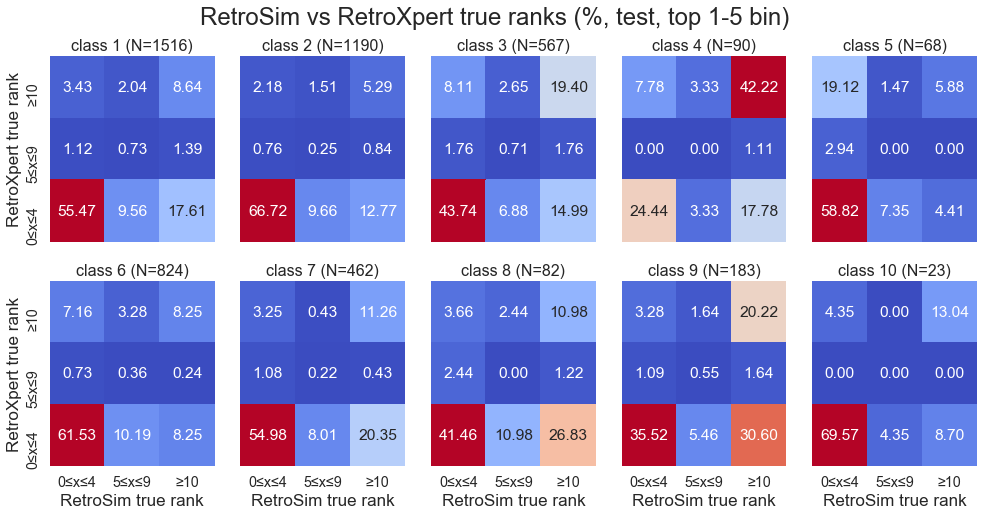

In [13]:
phase = 'test'

retrosim_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200topk_200maxk_noGT_typed_{phase}.csv', 
                        index_col=None, dtype='str')
retroxpert_props_df = pd.read_csv(f'rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_noGT_typed_{phase}.csv', 
                             index_col=None, dtype='str')

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axs = axs.flatten()
fig.suptitle(f'RetroSim vs RetroXpert true ranks (%, {phase}, top 1-5 bin)', fontsize=24, y=1.03)
for rxn_type in range(1, 11):
    retrosim_props = retrosim_props_df.fillna('9999')
    retrosim_props = retrosim_props[retrosim_props.rxn_type == str(rxn_type)]
    
    retroxpert_props = retroxpert_props_df.fillna('9999')
    retroxpert_props = retroxpert_props[retroxpert_props.rxn_type == str(rxn_type)]

    ranks_combined = pd.concat([retroxpert_props.rank_of_true_precursor, retrosim_props.rank_of_true_precursor], axis=1)
    ranks_combined.columns = ['retroxpert_true_rank', 'retrosim_true_rank']
    ranks_combined = ranks_combined.astype('int')

    rank_matrix = np.zeros((3, 3), dtype='int32') # row = retrosim, col = retroxpert
    for row_idx in range(ranks_combined.shape[0]):
        retroxpert_true_rank = ranks_combined.iloc[row_idx, 0]
        retrosim_true_rank = ranks_combined.iloc[row_idx, 1]
        if 9 >= retroxpert_true_rank >= 5:
            row = 1
        elif retroxpert_true_rank > 9:
            row = 2
        else:
            row = 0
        if 9 >= retrosim_true_rank >= 5:
            col = 1
        elif retrosim_true_rank > 9:
            col = 2
        else:
            col = 0
        rank_matrix[row, col] += 1

    sns.set(font_scale=1.3)
#     f, ax = plt.subplots(figsize=(3,3))
#     ax = axs[rxn_type-1
    sns.heatmap(
        data=np.flip(rank_matrix / ranks_combined.shape[0] * 100, axis=0),
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        cbar=False,
        ax=axs[rxn_type-1]
    );
    
    axs[rxn_type-1].set_title(f'class {rxn_type} (N={ranks_combined.shape[0]})', fontsize=16);
    axs[rxn_type-1].set_xticklabels(['0≤x≤4', '5≤x≤9', '≥10']);
    if rxn_type-1 >= 5:
        axs[rxn_type-1].set_xlabel('RetroSim true rank', fontsize=17);
    axs[rxn_type-1].set_yticklabels(reversed(['0≤x≤4', '5≤x≤9', '≥10']));
    if rxn_type-1 == 0 or rxn_type-1 == 5:
        axs[rxn_type-1].set_ylabel('RetroXpert true rank', fontsize=17);

plt.tight_layout()
plt.savefig(f'rxnebm/analysis/GLN_vs_retrosim_rank_matrix_typed_top1to5_{phase}.png', bbox_inches = 'tight')

- Class 4 is the worst for both GLN & RetroSim, followed by 9, 3 and 8 (using % in bottomleft-most box)
- Class 4 is the worst for both GLN & RetroXpert, followed by 9, 3 and 8 (using % in bottomleft-most box)
- Class 4 is the worst for both RetroSim & RetroXpert, followed by 9, 3 and 8 (using % in bottomleft-most box) <br><br>
**Interesting observations:**
- barely any overlap in rank 5-9 of both models (centre box), <1% in every reaction class, in general centre row
- RetroXpert barely has reactions in rank 5-9 it seems, so either it got them in rank 0-4, or 10+ (which includes totally wrong, ie not in top-50/infinity)
- RetroXpert relatively inferior in class 5? gets 19.12% in rank-10 or worse when RetroSim gets it right

### performance breakdown by rxn_type

In [125]:
proposals_typed = {}
total_typed = []
accs_typed = defaultdict(lambda: defaultdict(list)) # main_key = proposer, inner_key = K, value = List[top-K accuracy by rxn_type]
proposers = ['RetroSim', 'GLN', 'RetroXpert']
proposal_prefixes = [
    'retrosim_200topk_200maxk_noGT',
    'GLN_retrain_200topk_200maxk_noGT',
    'retroxpert_200topk_200maxk_noGT'
]
phase = 'test' # just work with test set for now
for i, proposer in enumerate(proposers):
    this_proposal_typed = pd.read_csv(
        f'rxnebm/data/cleaned_data/{proposal_prefixes[i]}_typed_test.csv', 
        index_col=None, dtype='str'
    )
    proposals_typed[proposer] = this_proposal_typed.fillna('9999')
    
    print('#'*20, f'{phase}, {proposer}', '#'*20)
    for rxn_type in range(1, 11):
        ranks_typed = proposals_typed[proposer][proposals_typed[proposer].rxn_type == str(rxn_type)].rank_of_true_precursor.values.astype('int')
        for n in [1, 10]: #[1, 3, 5, 10, 20, 50]:
            total = float(len(ranks_typed))
            accs_typed[proposer][n].append(100*sum([r+1 <= n for r in ranks_typed]) / total) 
            if n == 1 and len(total_typed) < 10:
                total_typed.append(str(int(total)))
        print(
            f'rxn_type: {rxn_type} (N={int(total):d}),\t'
            f'top-1 acc: {accs_typed[proposer][1][-1]:.2f}%,'
            f'\ttop-10 acc: {accs_typed[proposer][10][-1]:.2f}%'
        )
    print('\n')
    
for rxn_type in range(1, 11):
    for n in [1, 10]:
        accs_typed['mean'][n].append(
            (accs_typed['RetroSim'][n][rxn_type-1] + accs_typed['GLN'][n][rxn_type-1] + accs_typed['RetroXpert'][n][rxn_type-1])/3
        )

#################### test, RetroSim ####################
rxn_type: 1 (N=1516),	top-1 acc: 36.74%,	top-10 acc: 72.36%
rxn_type: 2 (N=1190),	top-1 acc: 43.03%,	top-10 acc: 81.09%
rxn_type: 3 (N=567),	top-1 acc: 30.34%,	top-10 acc: 63.84%
rxn_type: 4 (N=90),	top-1 acc: 24.44%,	top-10 acc: 38.89%
rxn_type: 5 (N=68),	top-1 acc: 48.53%,	top-10 acc: 89.71%
rxn_type: 6 (N=824),	top-1 acc: 34.47%,	top-10 acc: 83.25%
rxn_type: 7 (N=462),	top-1 acc: 29.00%,	top-10 acc: 67.97%
rxn_type: 8 (N=82),	top-1 acc: 25.61%,	top-10 acc: 60.98%
rxn_type: 9 (N=183),	top-1 acc: 16.39%,	top-10 acc: 47.54%
rxn_type: 10 (N=23),	top-1 acc: 60.87%,	top-10 acc: 78.26%


#################### test, GLN ####################
rxn_type: 1 (N=1516),	top-1 acc: 50.13%,	top-10 acc: 87.40%
rxn_type: 2 (N=1190),	top-1 acc: 66.72%,	top-10 acc: 94.37%
rxn_type: 3 (N=567),	top-1 acc: 34.04%,	top-10 acc: 75.49%
rxn_type: 4 (N=90),	top-1 acc: 38.89%,	top-10 acc: 60.00%
rxn_type: 5 (N=68),	top-1 acc: 63.24%,	top-10 acc: 94.12%
rxn_t

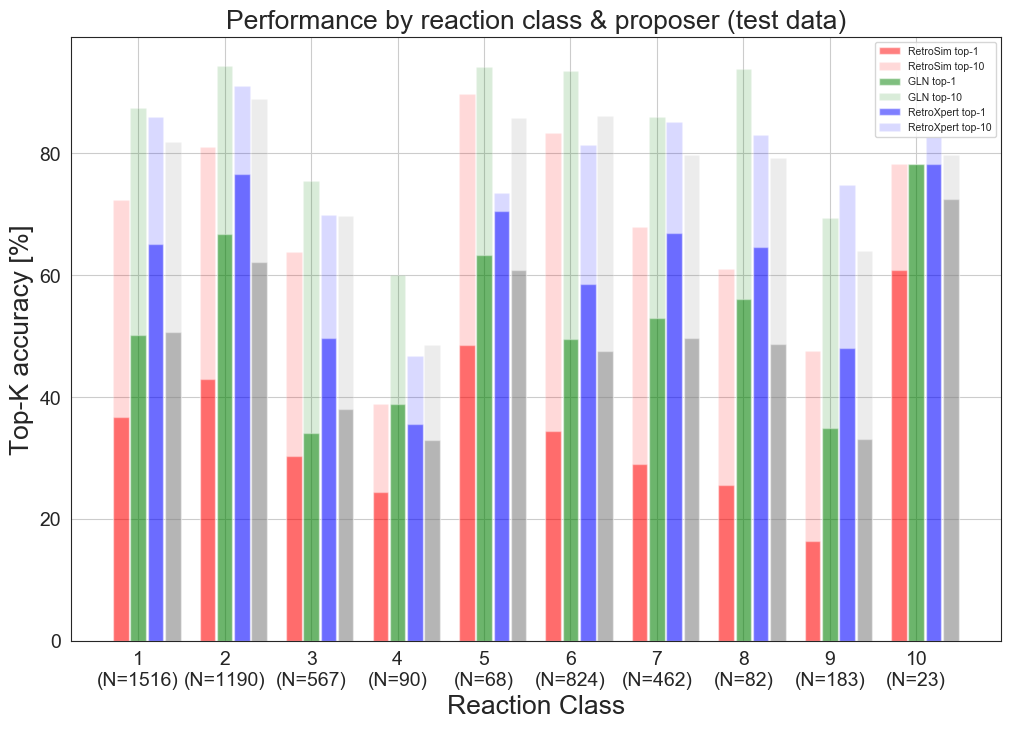

In [132]:
n = 10 # rxn classes
fig = plt.figure(figsize=(12, 8), dpi = 100)
colors_back = colors_fore = ['r', 'g', 'b', 'grey']

for offset, proposer in enumerate(proposers + ['mean']):
    plt.bar(
        np.arange(n) + (offset-1)*.20, 
        accs_typed[proposer][1], alpha=0.5, width=0.18,
        color=colors_fore[offset]
    )
    plt.bar(
        np.arange(n) + (offset-1)*.20, 
        accs_typed[proposer][10], alpha=0.15, width=0.18,
        color=colors_back[offset]
    )

plt.xlabel(f'Reaction Class', size=19)
xticks = np.arange(1, 11).astype('str')
for i, tick in enumerate(xticks):
    xticks[i] = tick + f'\n(N={total_typed[i]})'
plt.xticks(np.arange(0, n, 1), labels=xticks, size=14)
plt.ylabel('Top-K accuracy [%]', size=19)
plt.yticks(size=14)
plt.title(f'Performance by reaction class & proposer ({phase} data)', size=19)
plt.legend([
    proposers[0] + ' top-1', proposers[0] + ' top-10', 
    proposers[1] + ' top-1', proposers[1] + ' top-10', 
    proposers[2] + ' top-1', proposers[2] + ' top-10'
], prop={'size': 7.5})
plt.grid(True)

plt.savefig(f'rxnebm/analysis/compare_rxn_type_topk_3proposers_test.png', bbox_inches = 'tight')
plt.show()

## load proposal csv

In [7]:
retroxpert_props = pd.read_csv('rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_200beam_valid.csv', index_col=None, dtype='str')
retroxpert_props = retroxpert_props.fillna('9999') 
retroxpert_props_np = retroxpert_props.values 
retroxpert_props.head(5)

,orig_rxn_smi,prod_smi,true_precursors,rank_of_true_precursor,cand_precursor_1,cand_precursor_2,cand_precursor_3,cand_precursor_4,cand_precursor_5,cand_precursor_6,...,cand_precursor_191,cand_precursor_192,cand_precursor_193,cand_precursor_194,cand_precursor_195,cand_precursor_196,cand_precursor_197,cand_precursor_198,cand_precursor_199,cand_precursor_200
0,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Nc4cccc(Br)...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Nc4cccc(-c5...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Nc4cccc(Br)...,0,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Nc4cccc(Br)...,Brc1cccnc1.CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Nc4cccc(Br)...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Nc4cccc(Br)...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Nc4cccc(Br)...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Nc4cccc(Br)...,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
1,CC(C)(C)OC(=O)Nc1sc(Br)cc1C(=O)N1CCC(N2CCCC3(C...,CC(C)(C)OC(=O)Nc1sc(-c2ccc(C#N)cc2)cc1C(=O)N1C...,CC(C)(C)OC(=O)Nc1sc(Br)cc1C(=O)N1CCC(N2CCCC3(C...,0,CC(C)(C)OC(=O)Nc1sc(Br)cc1C(=O)N1CCC(N2CCCC3(C...,CC1(C)CC(=O)N(c2sc(Br)cc2C(=O)N2CCC(N3CCCC34CC...,CC(C)(C)OC(=O)Nc1sc(Cl)cc1C(=O)N1CCC(N2CCCC3(C...,CC1(C)CC(=O)N(C(=O)c2sc(Br)cc2C(=O)N2CCC(N3CCC...,CC1(C)CC(=O)N(c2ccc(C#N)cc2)CCN(C(=O)c2sc(Br)c...,CC1(C)CC(=O)N(c2sc(Br)cc2C(=O)N2CCC(N3CCCC34CC...,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
2,Nc1ccc(CCc2ccccn2)nc1.O=C(Cl)c1ccccc1-c1ccc(C(...,O=C(Nc1ccc(CCc2ccccn2)nc1)c1ccccc1-c1ccc(C(F)(...,Nc1ccc(CCc2ccccn2)nc1.O=C(Cl)c1ccccc1-c1ccc(C(...,1,Nc1ccc(CCc2ccccn2)nc1.O=C(O)c1ccccc1-c1ccc(C(F...,Nc1ccc(CCc2ccccn2)nc1.O=C(Cl)c1ccccc1-c1ccc(C(...,Nc1ccc(CCc2cccnn2)nc1.O=C(O)c1ccccc1-c1ccc(C(F...,Nc1ccc(CCc2ccncn2)nc1.O=C(O)c1ccccc1-c1ccc(C(F...,Nc1ccc(CCc2ccccn2)nc1.O=C(O)c1ccccc1-c1ccc(CC(...,Nc1ccc(Cc2ccccn2)nc1.O=C(O)c1ccccc1-c1ccc(C(F)...,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
3,CC(C)(C)OC(=O)N1CCCN(c2nc3ccccc3[nH]2)CC1.COCC...,COCCn1c(N2CCCN(C(=O)OC(C)(C)C)CC2)nc2ccccc21,CC(C)(C)OC(=O)N1CCCN(c2nc3ccccc3[nH]2)CC1.COCCCl,1,CC(C)(C)OC(=O)N1CCCN(c2nc3ccccc3[nH]2)CC1.COCCBr,CC(C)(C)OC(=O)N1CCCN(c2nc3ccccc3[nH]2)CC1.COCCCl,CC(C)(C)OC(=O)N1CCN(c2nc3ccccc3[nH]2)CC1.COCCBr,CC(C)(C)OC(=O)N1CCCN(c2nc3ccccc3[nH]2)CC1.COCCI,CC(C)OC(=O)N1CCCN(c2nc3ccccc3[nH]2)CC1.COCCBr,CC(C)(C)OC(=O)N1CCCN(c2nc3ccccc3[nH]2)C1.COCCBr,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
4,O=C(Cl)c1ccccc1.c1ccc(CNCCCSc2ccncc2)cc1>>O=C(...,O=C(c1ccccc1)N(CCCSc1ccncc1)Cc1ccccc1,O=C(Cl)c1ccccc1.c1ccc(CNCCCSc2ccncc2)cc1,0,O=C(Cl)c1ccccc1.c1ccc(CNCCCSc2ccncc2)cc1,O=C(O)c1ccccc1.c1ccc(CNCCCSc2ccncc2)cc1,O=C(O)c1ccc(CNCCCSc2ccncc2)cc1.[Mg+]c1ccccc1,O=C(Cl)c1ccc(CNCCCSc2ccncc2)cc1.[Mg+]c1ccccc1,O=C(Cl)c1ccc(CNCCCSc2ccncc2)cc1.c1ccccc1,Clc1ccccc1.c1ccc(CNCCCSc2ccncc2)cc1,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999


In [2]:
retrosim_props = pd.read_csv('rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_valid.csv', index_col=None, dtype='str')
retrosim_props = retrosim_props.fillna('9999') 
retrosim_props_np = retrosim_props.values 
retrosim_props.head(5)

,orig_rxn_smi,prod_smi,true_precursors,rank_of_true_precursor,cand_precursor_1,cand_precursor_2,cand_precursor_3,cand_precursor_4,cand_precursor_5,cand_precursor_6,...,cand_precursor_191,cand_precursor_192,cand_precursor_193,cand_precursor_194,cand_precursor_195,cand_precursor_196,cand_precursor_197,cand_precursor_198,cand_precursor_199,cand_precursor_200
0,Br[c:1]1[cH:2][cH:3][cH:4][c:5]([NH:6][c:7]2[c...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Nc4cccc(-c5...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Nc4cccc(Br)...,13,Brc1cccc(-c2cccnc2)c1.CCOC(=O)C1(c2ccc(-c3ccc(...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Br)cc3)cc2)...,CC1(C)OB(c2cccnc2)OC1(C)C.CCOC(=O)C1(c2ccc(-c3...,Brc1cccnc1.CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4...,CCOC(=O)C1(c2ccc(-c3ccc(B4OC(C)(C)C(C)(C)O4)cc...,CCOC(=O)C1(c2ccc(Br)cc2)CC1.Cc1noc(-c2ccc(B3OC...,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
1,Br[c:1]1[s:2][c:3]([NH:4][C:5]([O:6][C:7]([CH3...,CC(C)(C)OC(=O)Nc1sc(-c2ccc(C#N)cc2)cc1C(=O)N1C...,CC(C)(C)OC(=O)Nc1sc(Br)cc1C(=O)N1CCC(N2CCCC3(C...,7,CC(C)(C)OC(=O)Nc1sc(B2OC(C)(C)C(C)(C)O2)cc1C(=...,CC(C)(C)OC(=O)Nc1sc(OS(=O)(=O)C(F)(F)F)cc1C(=O...,CC(C)(C)OC(=O)Nc1sc(Br)cc1C(=O)N1CCC(N2CCCC3(C...,CC(C)(C)OC(=O)Nc1sc(-c2ccc(C#N)cc2)cc1C(=O)N1C...,CC(C)(C)OC(=O)Nc1sc(B2OC(C)(C)C(C)(C)O2)cc1C(=...,CC(C)(C)OC(=O)Nc1sc(-c2ccc(C#N)cc2)cc1C(=O)N1C...,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
2,O=[CH2:1].[cH:2]1[n:3][cH:4][c:5](-[c:6]2[cH:7...,CN1CCc2nc(Nc3ccc(-c4cnco4)cc3)nc(NCC3CCOCC3)c2C1,C=O.c1ncc(-c2ccc(Nc3nc4c(c(NCC5CCOCC5)n3)CNCC4...,0,C=O.c1ncc(-c2ccc(Nc3nc4c(c(NCC5CCOCC5)n3)CNCC4...,CN1CCc2nc(Nc3ccc(-c4cnco4)cc3)nc(NCC3=CCOCC3)c2C1,CN1CCc2nc(Cl)nc(NCC3CCOCC3)c2C1.Nc1ccc(-c2cnco...,CN1CCc2nc(Nc3ccc(-c4cnco4)cc3)nc(NC=C3CCOCC3)c2C1,CN1CCc2nc(Nc3ccc(-c4cnco4)cc3)nc(N(CC3CCOCC3)C...,Brc1cnco1.CN1CCc2nc(Nc3ccc(B4OC(C)(C)C(C)(C)O4...,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
3,[OH:1][CH:2]([c:3]1[cH:4][cH:5][cH:6][cH:7][cH...,O=C(c1ccccc1)c1nn2ccccc2c1-c1ccnc(NC2CCCC2)n1,OC(c1ccccc1)c1nn2ccccc2c1-c1ccnc(NC2CCCC2)n1,31,CCOC(OCC)(c1ccccc1)c1nn2ccccc2c1-c1ccnc(NC2CCC...,Clc1ccnc(NC2CCCC2)n1.O=C(c1ccccc1)c1nn2ccccc2c...,NC1CCCC1.O=C(c1ccccc1)c1nn2ccccc2c1-c1ccnc(Cl)n1,O=C(c1ccccc1)c1nn2ccccc2c1Cl.OB(O)c1ccnc(NC2CC...,Brc1ccnc(NC2CCCC2)n1.O=C(c1ccccc1)c1nn2ccccc2c...,O=C(c1ccccc1)c1nn2ccccc2c1Br.OB(O)c1ccnc(NC2CC...,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
4,CC[O:1][C:2](=[O:3])[c:4]1[cH:5][nH:6][c:7]2[c...,O=C(O)c1c[nH]c2c(F)cc(I)cc2c1=O,CCOC(=O)c1c[nH]c2c(F)cc(I)cc2c1=O,0,CCOC(=O)c1c[nH]c2c(F)cc(I)cc2c1=O,COC(=O)c1c[nH]c2c(F)cc(I)cc2c1=O,O=C(O)Cl.O=c1cc[nH]c2c(F)cc(I)cc12,O=C(O)c1cn(C(=O)c2ccccc2)c2c(F)cc(I)cc2c1=O,CC(C)(C)OC(=O)c1c[nH]c2c(F)cc(I)cc2c1=O,9999,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999


In [24]:
gln_props = pd.read_csv('rxnebm/data/cleaned_data/GLN_retrain_200topk_200maxk_200beam_valid.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values 
gln_props.head(5)

,orig_rxn_smi,prod_smi,true_precursors,rank_of_true_precursor,cand_precursor_1,cand_precursor_2,cand_precursor_3,cand_precursor_4,cand_precursor_5,cand_precursor_6,...,cand_precursor_191,cand_precursor_192,cand_precursor_193,cand_precursor_194,cand_precursor_195,cand_precursor_196,cand_precursor_197,cand_precursor_198,cand_precursor_199,cand_precursor_200
0,Br[c:1]1[cH:2][cH:3][cH:4][c:5]([NH:6][c:7]2[c...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Nc4cccc(-c5...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Nc4cccc(Br)...,3,Brc1cccc(-c2cccnc2)c1.CCOC(=O)C1(c2ccc(-c3ccc(...,CC1(C)OB(c2cccnc2)OC1(C)C.CCOC(=O)C1(c2ccc(-c3...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Br)cc3)cc2)...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4Nc4cccc(Br)...,Brc1cccnc1.CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4...,CCOC(=O)C1(c2ccc(-c3ccc(-c4onc(C)c4N)cc3)cc2)C...,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
1,Br[c:1]1[s:2][c:3]([NH:4][C:5]([O:6][C:7]([CH3...,CC(C)(C)OC(=O)Nc1sc(-c2ccc(C#N)cc2)cc1C(=O)N1C...,CC(C)(C)OC(=O)Nc1sc(Br)cc1C(=O)N1CCC(N2CCCC3(C...,4,CC(C)(C)OC(=O)Nc1sc(-c2ccc(C#N)cc2)cc1C(=O)O.C...,CC(C)(C)OC(=O)Nc1sc(-c2ccc(C#N)cc2)cc1C(=O)[O-...,CC1(C)CC2(CCCN(C3CCNCC3)C2)C(=O)O1.COC(=O)c1cc...,CC1(C)CC2(CCCN(C3CCNCC3)C2)C(=O)O1.CCOC(=O)c1c...,CC(C)(C)OC(=O)Nc1sc(Br)cc1C(=O)N1CCC(N2CCCC3(C...,CC(C)(C)OC(=O)Nc1sc(Br)cc1C(=O)N1CCC(N2CCCC3(C...,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
2,O=[CH2:1].[cH:2]1[n:3][cH:4][c:5](-[c:6]2[cH:7...,CN1CCc2nc(Nc3ccc(-c4cnco4)cc3)nc(NCC3CCOCC3)c2C1,C=O.c1ncc(-c2ccc(Nc3nc4c(c(NCC5CCOCC5)n3)CNCC4...,0,C=O.c1ncc(-c2ccc(Nc3nc4c(c(NCC5CCOCC5)n3)CNCC4...,CO.c1ncc(-c2ccc(Nc3nc4c(c(NCC5CCOCC5)n3)CNCC4)...,CI.c1ncc(-c2ccc(Nc3nc4c(c(NCC5CCOCC5)n3)CNCC4)...,CN1CCc2nc(Nc3ccc(-c4cnco4)cc3)nc(Cl)c2C1.NCC1C...,CN1CCc2nc(Nc3ccc(-c4cnco4)cc3)nc(NCC3CCOCC3)c2...,CN1CCc2nc(Nc3ccc(-c4cnco4)cc3)nc(F)c2C1.NCC1CC...,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
3,[OH:1][CH:2]([c:3]1[cH:4][cH:5][cH:6][cH:7][cH...,O=C(c1ccccc1)c1nn2ccccc2c1-c1ccnc(NC2CCCC2)n1,OC(c1ccccc1)c1nn2ccccc2c1-c1ccnc(NC2CCCC2)n1,0,OC(c1ccccc1)c1nn2ccccc2c1-c1ccnc(NC2CCCC2)n1,NC1CCCC1.O=C(c1ccccc1)c1nn2ccccc2c1-c1ccnc(Cl)n1,NC1CCCC1.O=C(c1ccccc1)c1nn2ccccc2c1-c1ccnc(Br)n1,NC1CCCC1.O=C(c1ccccc1)c1nn2ccccc2c1-c1ccnc(F)n1,COc1ccc(CN(c2nccc(-c3c(C(=O)c4ccccc4)nn4ccccc3...,CON(C)C(=O)c1nn2ccccc2c1-c1ccnc(NC2CCCC2)n1.[M...,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
4,CC[O:1][C:2](=[O:3])[c:4]1[cH:5][nH:6][c:7]2[c...,O=C(O)c1c[nH]c2c(F)cc(I)cc2c1=O,CCOC(=O)c1c[nH]c2c(F)cc(I)cc2c1=O,0,CCOC(=O)c1c[nH]c2c(F)cc(I)cc2c1=O,COC(=O)c1c[nH]c2c(F)cc(I)cc2c1=O,O=C(OCc1ccccc1)c1c[nH]c2c(F)cc(I)cc2c1=O,CC(C)(C)OC(=O)c1c[nH]c2c(F)cc(I)cc2c1=O,O=C(OO)c1c[nH]c2c(F)cc(I)cc2c1=O,COc1ccc(COC(=O)c2c[nH]c3c(F)cc(I)cc3c2=O)cc1,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999


## canonicalize all GLN proposals

In [2]:
for phase in ['train', 'valid', 'test']:
    phase_topk = 200
    gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_retrain_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
    gln_props = gln_props.fillna('9999') 
    gln_props_np = gln_props.values 
    dup_count = 0
    for idx in tqdm(range(gln_props_np.shape[0]), desc=f'Processing {phase}'):
        this_rxn_precs = gln_props_np[idx][4:]
        this_rxn_seen = []
        for prop in this_rxn_precs:
            if prop == '9999':
                break
            else:
                prop = Chem.MolToSmiles(Chem.MolFromSmiles(prop), True)
                if prop not in this_rxn_seen:
                    this_rxn_seen.append(prop)
                else:
                    dup_count += 1 / gln_props_np.shape[0]
        if len(this_rxn_seen) < phase_topk:
            this_rxn_seen.extend(['9999'] * (phase_topk - len(this_rxn_seen)))
        else:
            this_rxn_seen = this_rxn_seen[:phase_topk]
        gln_props.iloc[idx, 4:] = this_rxn_seen
    print(f'dup count for {phase}: {dup_count}')
    gln_props.to_csv(f'rxnebm/data/cleaned_data/GLN_retrain_cano_200topk_200maxk_200beam_{phase}.csv', index=False)

Processing train: 100%|██████████████████████████████████████████████████████████| 39713/39713 [32:12<00:00, 20.55it/s]


dup count for train: 0


Processing valid: 100%|████████████████████████████████████████████████████████████| 4989/4989 [04:09<00:00, 19.96it/s]


dup count for valid: 0


Processing test: 100%|█████████████████████████████████████████████████████████████| 5005/5005 [03:41<00:00, 22.58it/s]


dup count for test: 0


## double check that RetroSim/RetroXpert has no duplicate proposals for each product SMILES

In [7]:
for phase in ['train', 'valid', 'test']:
    retrosim_props = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_{phase}.csv', index_col=None, dtype='str')
    retrosim_props = retrosim_props.fillna('9999') 
    retrosim_props_np = retrosim_props.values

    dup_count = 0
    for idx in tqdm(range(retrosim_props.shape[0])):
        retrosim_props = retrosim_props_np[idx][4 : ]
        seen = set()
        for prop in retrosim_props:
            if prop == '9999':
                break

            if prop not in seen:
                seen.add(prop)
            else:
                dup_count += 1

    print(dup_count / retrosim_props.shape[0])

0.0
0.0
0.0


In [8]:
dup_count = 0
for idx in tqdm(range(retroxpert_props.shape[0])):
    retroxpert_props = retroxpert_props_np[idx][4 : ]
    seen = set ()
    for prop in retroxpert_props:
        if prop == '9999':
            break
            
        if prop not in seen:
            seen.add(prop)
        else:
            dup_count += 1
            
print(dup_count / retroxpert_props.shape[0])

100%|███████████████████████████████████████████████████████████████████████████| 4989/4989 [00:00<00:00, 38778.50it/s]

0.0


## analyze how much overlapping proposals are present in top50 (regardless of rank)

### GLN vs RetroSim

In [9]:
gln_props = pd.read_csv('rxnebm/data/cleaned_data/GLN_retrain_cano_200topk_200maxk_200beam_valid.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values 

retrosim_props = pd.read_csv('rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_valid.csv', index_col=None, dtype='str')
retrosim_props = retrosim_props.fillna('9999') 
retrosim_props_np = retrosim_props.values

# valid
topk = 50
topk_overlap, topk_overlap_incl9999 = 0, 0
for idx in range(gln_props.shape[0]):
    gln_topk = set(gln_props_np[idx][4 : 4 + topk])
    retrosim_topk = set(retrosim_props_np[idx][4 : 4 + topk])
    
    topk_overlap_incl9999 += len(gln_topk & retrosim_topk) / gln_props.shape[0]
    
    if '9999' in gln_topk:
        gln_topk.remove('9999')
    if '9999' in retrosim_topk:
        retrosim_topk.remove('9999')
    
    topk_overlap += len(gln_topk & retrosim_topk) / gln_props.shape[0]
     
print(f'Avg # of overlapping proposals in top-{topk} (ignore rank, no 9999): \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg # of overlapping proposals in top-{topk} (ignore rank, incl 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

Avg # of overlapping proposals in top-50 (ignore rank, no 9999): 	18.138 (36.276%)
Avg # of overlapping proposals in top-50 (ignore rank, incl 9999): 	18.332 (36.664%)


### GLN vs RetroXpert (so low overlap??)

In [4]:
gln_props = pd.read_csv('rxnebm/data/cleaned_data/GLN_retrain_cano_200topk_200maxk_200beam_valid.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values 

retroxpert_props = pd.read_csv('rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_200beam_valid.csv', index_col=None, dtype='str')
retroxpert_props = retroxpert_props.fillna('9999') 
retroxpert_props_np = retroxpert_props.values

# valid
topk = 50
topk_overlap, topk_overlap_incl9999 = 0, 0
for idx in range(gln_props.shape[0]):
    gln_topk = set(gln_props_np[idx][4 : 4 + topk])
    retroxpert_topk = set(retroxpert_props_np[idx][4 : 4 + topk])
    
    topk_overlap_incl9999 += len(gln_topk & retroxpert_topk) / gln_props.shape[0]
    
    if '9999' in gln_topk:
        gln_topk.remove('9999')
    if '9999' in retroxpert_topk:
        retroxpert_topk.remove('9999')
    
    topk_overlap += len(gln_topk & retroxpert_topk) / gln_props.shape[0]
     
print(f'Avg # of overlapping proposals in top-{topk} (ignore rank, no 9999): \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg # of overlapping proposals in top-{topk} (ignore rank, incl 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

Avg # of overlapping proposals in top-50 (ignore rank, no 9999): 	0.001 (0.002%)
Avg # of overlapping proposals in top-50 (ignore rank, incl 9999): 	0.038 (0.076%)


### RetroXpert vs RetroSim

In [8]:
retrosim_props = pd.read_csv('rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_valid.csv', index_col=None, dtype='str')
retrosim_props = retrosim_props.fillna('9999') 
retrosim_props_np = retrosim_props.values

retroxpert_props = pd.read_csv('rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_200beam_valid.csv', index_col=None, dtype='str')
retroxpert_props = retroxpert_props.fillna('9999') 
retroxpert_props_np = retroxpert_props.values

# valid
topk = 50
topk_overlap, topk_overlap_incl9999 = 0, 0
for idx in range(retrosim_props.shape[0]):
    retrosim_topk = set(retrosim_props_np[idx][4 : 4 + topk])
    retroxpert_topk = set(retroxpert_props_np[idx][4 : 4 + topk])
    
    topk_overlap_incl9999 += len(retrosim_topk & retroxpert_topk) / retrosim_props.shape[0]
    
    if '9999' in retrosim_topk:
        retrosim_topk.remove('9999')
    if '9999' in retroxpert_topk:
        retroxpert_topk.remove('9999')
    
    topk_overlap += len(retrosim_topk & retroxpert_topk) / retrosim_props.shape[0]
     
print(f'Avg # of overlapping proposals in top-{topk} (ignore rank, no 9999): \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg # of overlapping proposals in top-{topk} (ignore rank, incl 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

Avg # of overlapping proposals in top-50 (ignore rank, no 9999): 	0.001 (0.002%)
Avg # of overlapping proposals in top-50 (ignore rank, incl 9999): 	0.139 (0.278%)


## analyze overlaps in top10 (ignore rank)

In [13]:
for phase in ['valid', 'test']:
    print('#'*10, f'Data for {phase}','#'*10)
    retrosim_props = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_{phase}.csv', index_col=None, dtype='str')
    retrosim_props = retrosim_props.fillna('9999') 
    retrosim_props_np = retrosim_props.values 

    gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
    gln_props = gln_props.fillna('9999') 
    gln_props_np = gln_props.values 

    for topk in range(1, 11):
        topk_overlap, topk_overlap_incl9999 = 0, 0
        for idx in range(gln_props.shape[0]):
            gln_topk = set(gln_props_np[idx][4 : 4 + topk])
            retrosim_topk = set(retrosim_props_np[idx][4 : 4 + topk])

            topk_overlap_incl9999 += len(gln_topk & retrosim_topk) / gln_props.shape[0]

            if '9999' in gln_topk:
                gln_topk.remove('9999')
            if '9999' in retrosim_topk:
                retrosim_topk.remove('9999')

            topk_overlap += len(gln_topk & retrosim_topk) / gln_props.shape[0]

        print(f'Avg # of overlapping proposals in top-{topk} (ignore rank, no 9999): \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
        # print(f'Avg # of overlapping proposals in top-{topk} (ignore rank, incl 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')
        print()

########## Data for valid ##########
Avg # of overlapping proposals in top-1 (ignore rank, no 9999): 	0.380 (37.984%)

Avg # of overlapping proposals in top-2 (ignore rank, no 9999): 	0.738 (36.901%)

Avg # of overlapping proposals in top-3 (ignore rank, no 9999): 	1.097 (36.580%)

Avg # of overlapping proposals in top-4 (ignore rank, no 9999): 	1.456 (36.400%)

Avg # of overlapping proposals in top-5 (ignore rank, no 9999): 	1.818 (36.364%)

Avg # of overlapping proposals in top-6 (ignore rank, no 9999): 	2.187 (36.454%)

Avg # of overlapping proposals in top-7 (ignore rank, no 9999): 	2.567 (36.675%)

Avg # of overlapping proposals in top-8 (ignore rank, no 9999): 	2.948 (36.856%)

Avg # of overlapping proposals in top-9 (ignore rank, no 9999): 	3.345 (37.162%)

Avg # of overlapping proposals in top-10 (ignore rank, no 9999): 	3.759 (37.595%)

########## Data for test ##########
Avg # of overlapping proposals in top-1 (ignore rank, no 9999): 	0.378 (37.842%)

Avg # of overlapping pro

## analyze matching proposals by exact rank

In [16]:
for phase in ['valid', 'test']:
    print('#'*10, f'Data for {phase}','#'*10)
    retrosim_props = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_{phase}.csv', index_col=None, dtype='str')
    retrosim_props = retrosim_props.fillna('9999') 
    retrosim_props_np = retrosim_props.values 

    gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
    gln_props = gln_props.fillna('9999') 
    gln_props_np = gln_props.values 

    for topk in list(range(1, 11))+[50, 100]:
        topk_overlap, topk_overlap_incl9999 = 0, 0
        topk_counter, topk_counter_incl9999 = Counter(), Counter()
        
        for idx in range(gln_props.shape[0]):
            gln_topk = gln_props_np[idx][4 : 4 + topk]
            retrosim_topk = retrosim_props_np[idx][4 : 4 + topk]

            for i, prop in enumerate(gln_topk):
                if prop == retrosim_topk[i]:
                    if prop == '9999':
                        topk_overlap_incl9999 += (1 / gln_props.shape[0])
                        topk_counter_incl9999[i] += (1 / gln_props.shape[0])
                    else: # ignore 9999
                        topk_overlap += (1 / gln_props.shape[0])
                        topk_counter[i] += (1 / gln_props.shape[0])

        for i in range(topk): # fill in 0's to get same length for plotting bar graph
            if i not in topk_counter_incl9999:
                topk_counter_incl9999[i] = 0
            if i not in topk_counter:
                topk_counter[i] = 0

        print(f'Avg # of top-{topk} overlaps by exact rank (no 9999):  \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
        print(f'Avg # of top-{topk} overlaps by exact rank (only 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')
        print()

########## Data for valid ##########
Avg # of top-1 overlaps by exact rank (no 9999):  	0.380 (37.984%)
Avg # of top-1 overlaps by exact rank (only 9999): 	0.000 (0.000%)

Avg # of top-2 overlaps by exact rank (no 9999):  	0.487 (24.334%)
Avg # of top-2 overlaps by exact rank (only 9999): 	0.000 (0.000%)

Avg # of top-3 overlaps by exact rank (no 9999):  	0.553 (18.434%)
Avg # of top-3 overlaps by exact rank (only 9999): 	0.000 (0.000%)

Avg # of top-4 overlaps by exact rank (no 9999):  	0.594 (14.858%)
Avg # of top-4 overlaps by exact rank (only 9999): 	0.000 (0.000%)

Avg # of top-5 overlaps by exact rank (no 9999):  	0.626 (12.528%)
Avg # of top-5 overlaps by exact rank (only 9999): 	0.000 (0.000%)

Avg # of top-6 overlaps by exact rank (no 9999):  	0.653 (10.881%)
Avg # of top-6 overlaps by exact rank (only 9999): 	0.000 (0.003%)

Avg # of top-7 overlaps by exact rank (no 9999):  	0.680 (9.719%)
Avg # of top-7 overlaps by exact rank (only 9999): 	0.000 (0.006%)

Avg # of top-8 over

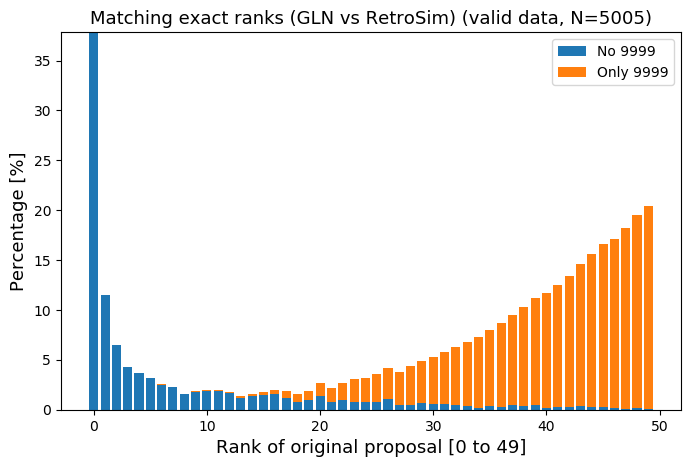

In [106]:
n = topk
lengths = [gln_props.shape[0]]
counter = topk_counter
counter_incl9999 = topk_counter_incl9999

fig = plt.figure(figsize=(8,5), dpi = 100)   
my_list = sorted(counter.items(), key=lambda x:x[0])  
freqs = np.array([x[1] for x in my_list]) * 100  
plt.bar(np.arange(n), freqs)

my_list_incl9999 = sorted(counter_incl9999.items(), key=lambda x:x[0])  
freqs_incl9999 = np.array([x[1] for x in my_list_incl9999]) * 100
plt.bar(np.arange(n), freqs_incl9999, bottom=freqs)
plt.xlabel('Rank of original proposal [0 to 49]', size=13)
plt.ylabel('Percentage [%]', size=13)
plt.legend(['No 9999', 'Only 9999']) 
plt.title(f'Matching exact ranks (GLN vs RetroSim) (valid data, N={lengths[0]})', size=13)
plt.savefig('rxnebm/analysis/retrosim_gln_exact_rank_match_valid.png', bbox_inches = 'tight')
plt.show()

## analyze by true rank

### GLN vs RetroSim

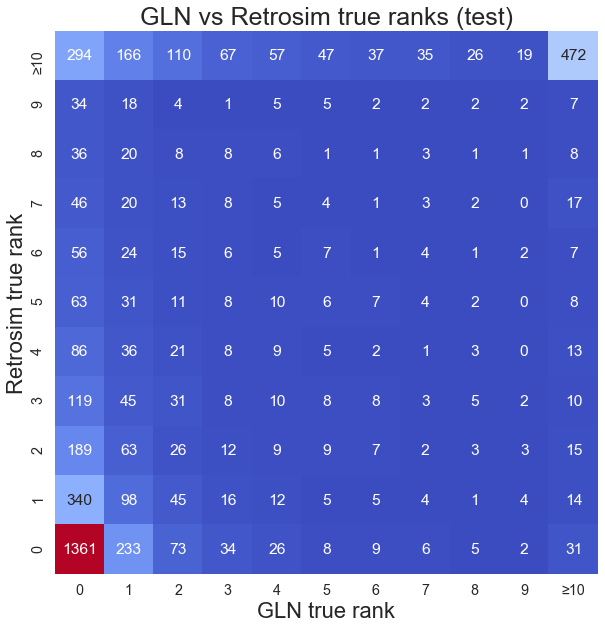

In [53]:
phase = 'test'

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values

retrosim_props = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_{phase}.csv', index_col=None, dtype='str')
retrosim_props = retrosim_props.fillna('9999') 
retrosim_props_np = retrosim_props.values 
    
ranks_combined = pd.concat([retrosim_props.rank_of_true_precursor, gln_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['retrosim_true_rank', 'gln_true_rank']
ranks_combined = ranks_combined.astype('int')

rank_matrix = np.zeros((11, 11), dtype='int32') # row = retrosim, col = retroxpert
for row_idx in range(ranks_combined.shape[0]):
    retrosim_true_rank = ranks_combined.iloc[row_idx, 0]
    gln_true_rank = ranks_combined.iloc[row_idx, 1]
    if retrosim_true_rank > 9:
        row = 10
    else:
        row = retrosim_true_rank
    if gln_true_rank > 9:
        col = 10
    else:
        col = gln_true_rank
    rank_matrix[row, col] += 1

sns.set(font_scale=1.3)
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(
    data=np.flip(rank_matrix, axis=0),
    annot=True,
    cmap='coolwarm',
    fmt='',
    square=True,
    cbar=False
);

ax.set_xticklabels(list(range(10))+['≥10']);
ax.set_xlabel('GLN true rank', fontsize=22);
ax.set_yticklabels(['≥10']+list(reversed(range(10))));
ax.set_ylabel('Retrosim true rank', fontsize=22);
ax.set_title(f'GLN vs Retrosim true ranks ({phase})', fontsize=25);
plt.savefig(f'rxnebm/analysis/GLN_vs_retrosim_rank_matrix_{phase}.png', bbox_inches = 'tight')

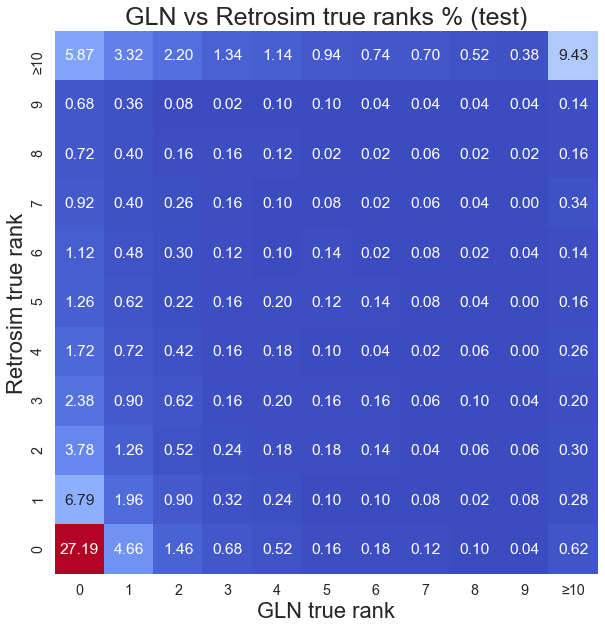

In [58]:
sns.set(font_scale=1.3)
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(
    data=np.flip(rank_matrix / ranks_combined.shape[0] * 100, axis=0),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=True,
    cbar=False
);

ax.set_xticklabels(list(range(10))+['≥10']);
ax.set_xlabel('GLN true rank', fontsize=22);
ax.set_yticklabels(['≥10']+list(reversed(range(10))));
ax.set_ylabel('Retrosim true rank', fontsize=22);
ax.set_title(f'GLN vs Retrosim true ranks % ({phase})', fontsize=25);
plt.savefig(f'rxnebm/analysis/GLN_vs_retrosim_rank_matrix_perc_{phase}.png', bbox_inches = 'tight')

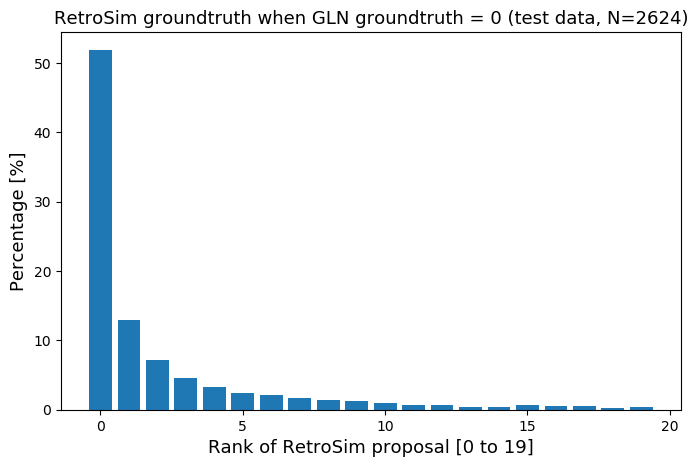

,gln_true_rank,retrosim_true_rank
gln_true_rank,1.000000,0.512065
retrosim_true_rank,0.512065,1.000000


In [48]:
phase = 'test'

retrosim_props = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_{phase}.csv', index_col=None, dtype='str')
retrosim_props = retrosim_props.fillna('9999') 
retrosim_props_np = retrosim_props.values 

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values 
    
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retrosim_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retrosim_true_rank']
ranks_combined = ranks_combined.astype('int')

topk = 20
retrosim_gt_dist = ranks_combined[ranks_combined['gln_true_rank'] == 0].retrosim_true_rank.value_counts().to_dict()
for key in range(0, topk): # for plotting bar graph
    if key not in retrosim_gt_dist:
        retrosim_gt_dist[key] = 0
        
n = topk
lengths = [ranks_combined[ranks_combined['gln_true_rank'] == 0].shape[0]]
counter = Counter(retrosim_gt_dist) 

fig = plt.figure(figsize=(8,5), dpi = 100)   
my_list = sorted(counter.items(), key=lambda x:x[0])[ : topk]
freqs = np.array([x[1] for x in my_list]) / lengths[0] * 100  
plt.bar(np.arange(n), freqs)  

plt.xlabel(f'Rank of RetroSim proposal [0 to {topk-1}]', size=13)
plt.xticks(np.arange(0, topk+1, 5))
plt.ylabel('Percentage [%]', size=13) 
plt.title(f'RetroSim groundtruth when GLN groundtruth = 0 ({phase} data, N={lengths[0]})', size=13)
plt.savefig(f'rxnebm/analysis/retrosim_gt_dist_gln0_top{topk}_{phase}.png', bbox_inches = 'tight')
plt.show()
ranks_combined.corr()

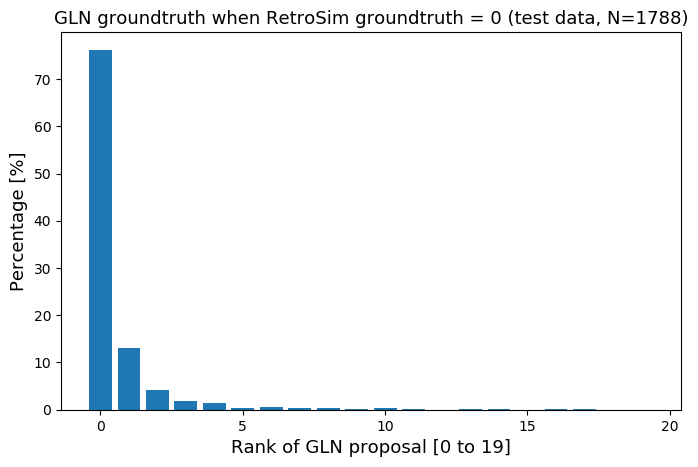

,gln_true_rank,retrosim_true_rank
gln_true_rank,1.000000,0.512065
retrosim_true_rank,0.512065,1.000000


In [47]:
phase = 'test'

retrosim_props = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_{phase}.csv', index_col=None, dtype='str')
retrosim_props = retrosim_props.fillna('9999') 
retrosim_props_np = retrosim_props.values 

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values 
    
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retrosim_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retrosim_true_rank']
ranks_combined = ranks_combined.astype('int')

topk = 20
gln_gt_dist = ranks_combined[ranks_combined['retrosim_true_rank'] == 0].gln_true_rank.value_counts().to_dict()
for key in range(0, topk): # for plotting bar graph
    if key not in gln_gt_dist:
        gln_gt_dist[key] = 0
        
n = topk
lengths = [ranks_combined[ranks_combined['retrosim_true_rank'] == 0].shape[0]]
counter = Counter(gln_gt_dist) 

fig = plt.figure(figsize=(8,5), dpi = 100)   
my_list = sorted(counter.items(), key=lambda x:x[0])[ : topk]
freqs = np.array([x[1] for x in my_list]) / lengths[0] * 100  
plt.bar(np.arange(n), freqs)  

plt.xlabel(f'Rank of GLN proposal [0 to {topk-1}]', size=13)
plt.xticks(np.arange(0, topk+1, 5))
plt.ylabel('Percentage [%]', size=13) 
plt.title(f'GLN groundtruth when RetroSim groundtruth = 0 ({phase} data, N={lengths[0]})', size=13)
plt.savefig(f'rxnebm/analysis/gln_gt_dist_retrosim0_top{topk}_{phase}.png', bbox_inches = 'tight')
plt.show()
ranks_combined.corr()

### GLN vs RetroXpert

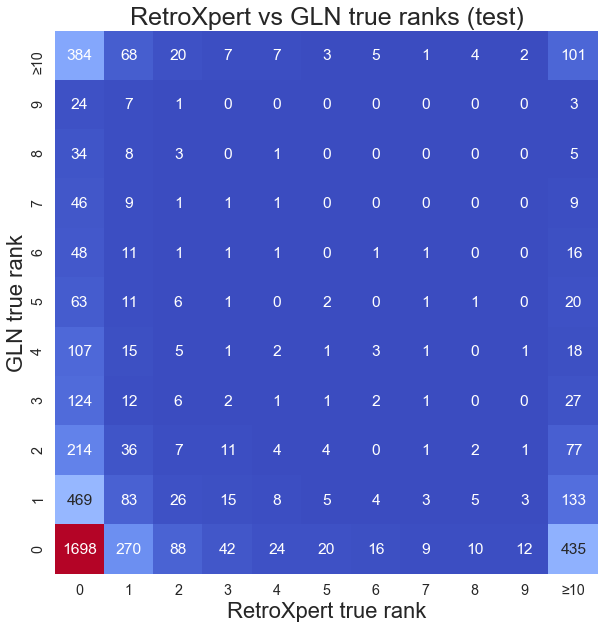

In [61]:
phase = 'test'

retroxpert_props = pd.read_csv(f'rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
retroxpert_props = retroxpert_props.fillna('9999') 
retroxpert_props_np = retroxpert_props.values 

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values 
    
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retroxpert_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retroxpert_true_rank']
ranks_combined = ranks_combined.astype('int')

rank_matrix = np.zeros((11, 11), dtype='int32') # row = gln, col = retroxpert
for row_idx in range(ranks_combined.shape[0]):
    gln_true_rank = ranks_combined.iloc[row_idx, 0]
    retroxpert_true_rank = ranks_combined.iloc[row_idx, 1]
    if gln_true_rank > 9:
        row = 10
    else:
        row = gln_true_rank
    if retroxpert_true_rank > 9:
        col = 10
    else:
        col = retroxpert_true_rank
    rank_matrix[row, col] += 1

sns.set(font_scale=1.3)
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(
    data=np.flip(rank_matrix, axis=0),
    annot=True,
    cmap='coolwarm',
    fmt='',
    square=True,
    cbar=False
);

ax.set_xticklabels(list(range(10))+['≥10']);
ax.set_yticklabels(['≥10']+list(reversed(range(10))));
ax.set_xlabel('RetroXpert true rank', fontsize=22);
ax.set_ylabel('GLN true rank', fontsize=22);
ax.set_title(f'RetroXpert vs GLN true ranks ({phase})', fontsize=25);
plt.savefig(f'rxnebm/analysis/retroxpert_vs_gln_rank_matrix_{phase}.png', bbox_inches = 'tight')

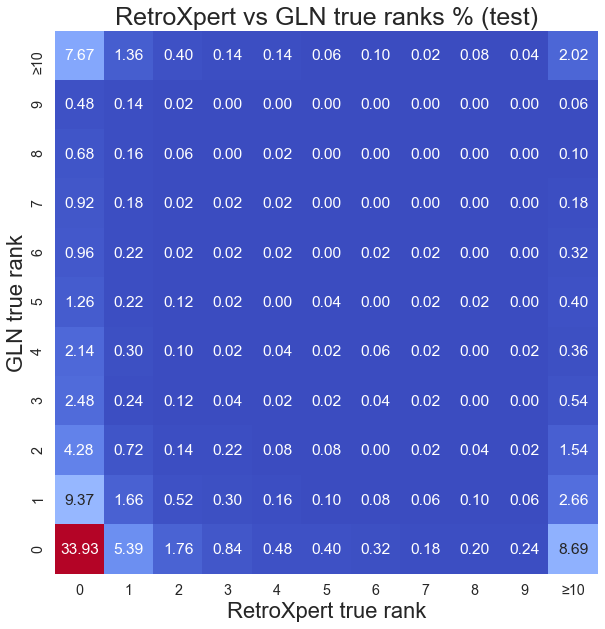

In [62]:
sns.set(font_scale=1.3)
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(
    data=np.flip(rank_matrix / ranks_combined.shape[0] * 100, axis=0),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=True,
    cbar=False
);

ax.set_xticklabels(list(range(10))+['≥10']);
ax.set_xlabel('RetroXpert true rank', fontsize=22);
ax.set_yticklabels(['≥10']+list(reversed(range(10))));
ax.set_ylabel('GLN true rank', fontsize=22);
ax.set_title(f'RetroXpert vs GLN true ranks % ({phase})', fontsize=25);
plt.savefig(f'rxnebm/analysis/retroxpert_vs_gln_rank_matrix_perc_{phase}.png', bbox_inches = 'tight')

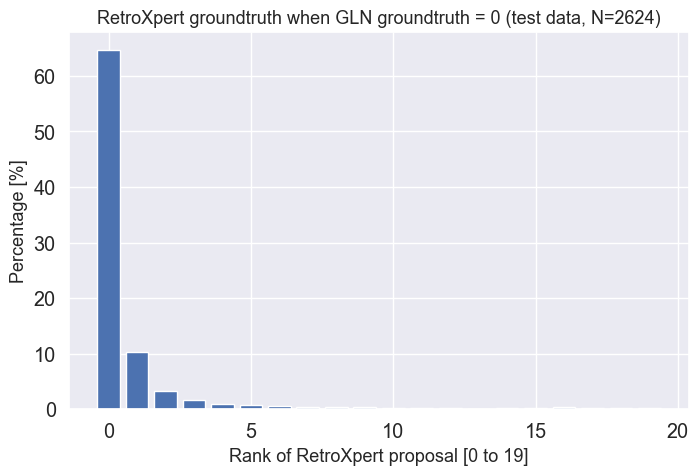

,gln_true_rank,retroxpert_true_rank
gln_true_rank,1.000000,-0.011912
retroxpert_true_rank,-0.011912,1.000000


In [37]:
phase = 'test'

retroxpert_props = pd.read_csv(f'rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
retroxpert_props = retroxpert_props.fillna('9999') 
retroxpert_props_np = retroxpert_props.values 

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values 
    
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retroxpert_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retroxpert_true_rank']
ranks_combined = ranks_combined.astype('int')

topk = 20
retroxpert_gt_dist = ranks_combined[ranks_combined['gln_true_rank'] == 0].retroxpert_true_rank.value_counts().to_dict()
for key in range(0, topk): # for plotting bar graph
    if key not in retroxpert_gt_dist:
        retroxpert_gt_dist[key] = 0
        
n = topk
lengths = [ranks_combined[ranks_combined['gln_true_rank'] == 0].shape[0]]
counter = Counter(retroxpert_gt_dist) 

fig = plt.figure(figsize=(8,5), dpi = 100)   
my_list = sorted(counter.items(), key=lambda x:x[0])[ : topk]
freqs = np.array([x[1] for x in my_list]) / lengths[0] * 100  
plt.bar(np.arange(n), freqs)  

plt.xlabel(f'Rank of RetroXpert proposal [0 to {topk-1}]', size=13)
plt.xticks(np.arange(0, topk+1, 5))
plt.ylabel('Percentage [%]', size=13) 
plt.title(f'RetroXpert groundtruth when GLN groundtruth = 0 ({phase} data, N={lengths[0]})', size=13)
plt.savefig(f'rxnebm/analysis/retroxpert_gt_dist_gln0_top{topk}_{phase}.png', bbox_inches = 'tight')
plt.show()
ranks_combined.corr()

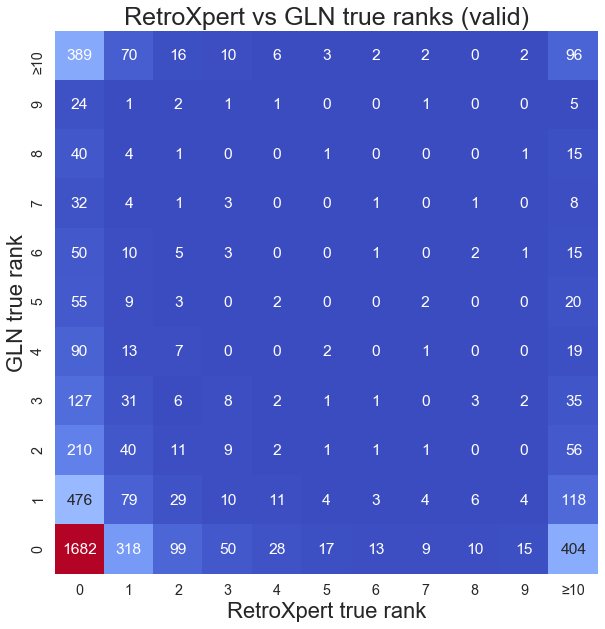

In [51]:
phase = 'valid'

retroxpert_props = pd.read_csv(f'rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
retroxpert_props = retroxpert_props.fillna('9999') 
retroxpert_props_np = retroxpert_props.values 

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values 
    
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retroxpert_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retroxpert_true_rank']
ranks_combined = ranks_combined.astype('int')

rank_matrix = np.zeros((11, 11), dtype='int32') # row = gln, col = retroxpert
for row_idx in range(ranks_combined.shape[0]):
    gln_true_rank = ranks_combined.iloc[row_idx, 0]
    retroxpert_true_rank = ranks_combined.iloc[row_idx, 1]
    if gln_true_rank > 9:
        row = 10
    else:
        row = gln_true_rank
    if retroxpert_true_rank > 9:
        col = 10
    else:
        col = retroxpert_true_rank
    rank_matrix[row, col] += 1

sns.set(font_scale=1.3)
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(
    data=np.flip(rank_matrix, axis=0),
    annot=True,
    cmap='coolwarm',
    fmt='',
    square=True,
    cbar=False
);

ax.set_xticklabels(list(range(10))+['≥10']);
ax.set_yticklabels(['≥10']+list(reversed(range(10))));
ax.set_xlabel('RetroXpert true rank', fontsize=22);
ax.set_ylabel('GLN true rank', fontsize=22);
ax.set_title(f'RetroXpert vs GLN true ranks ({phase})', fontsize=25);
plt.savefig(f'rxnebm/analysis/retroxpert_vs_gln_rank_matrix_{phase}.png', bbox_inches = 'tight')

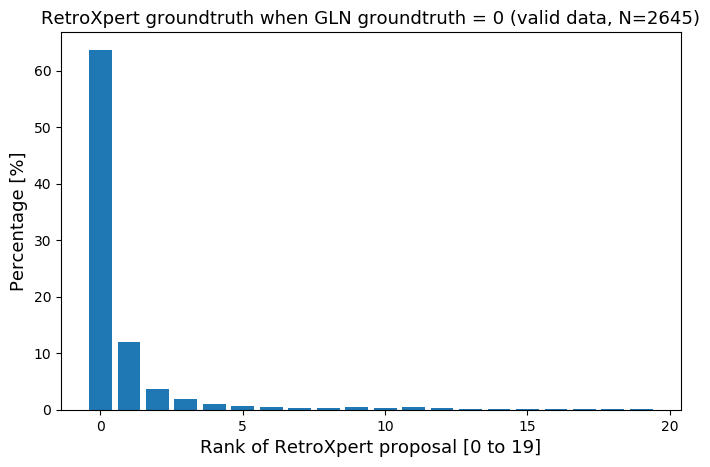

,gln_true_rank,retroxpert_true_rank
gln_true_rank,1.000000,0.001177
retroxpert_true_rank,0.001177,1.000000


In [13]:
phase = 'valid'

retroxpert_props = pd.read_csv(f'rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
retroxpert_props = retroxpert_props.fillna('9999') 
retroxpert_props_np = retroxpert_props.values 

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values 
    
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retroxpert_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retroxpert_true_rank']
ranks_combined = ranks_combined.astype('int')

topk = 20
retroxpert_gt_dist = ranks_combined[ranks_combined['gln_true_rank'] == 0].retroxpert_true_rank.value_counts().to_dict()
for key in range(0, topk): # for plotting bar graph
    if key not in retroxpert_gt_dist:
        retroxpert_gt_dist[key] = 0
        
n = topk
lengths = [ranks_combined[ranks_combined['gln_true_rank'] == 0].shape[0]]
counter = Counter(retroxpert_gt_dist) 

fig = plt.figure(figsize=(8,5), dpi = 100)   
my_list = sorted(counter.items(), key=lambda x:x[0])[ : topk]
freqs = np.array([x[1] for x in my_list]) / lengths[0] * 100  
plt.bar(np.arange(n), freqs)  

plt.xlabel(f'Rank of RetroXpert proposal [0 to {topk-1}]', size=13)
plt.xticks(np.arange(0, topk+1, 5))
plt.ylabel('Percentage [%]', size=13) 
plt.title(f'RetroXpert groundtruth when GLN groundtruth = 0 ({phase} data, N={lengths[0]})', size=13)
plt.savefig(f'rxnebm/analysis/retroxpert_gt_dist_gln0_top{topk}_{phase}.png', bbox_inches = 'tight')
plt.show()
ranks_combined.corr()

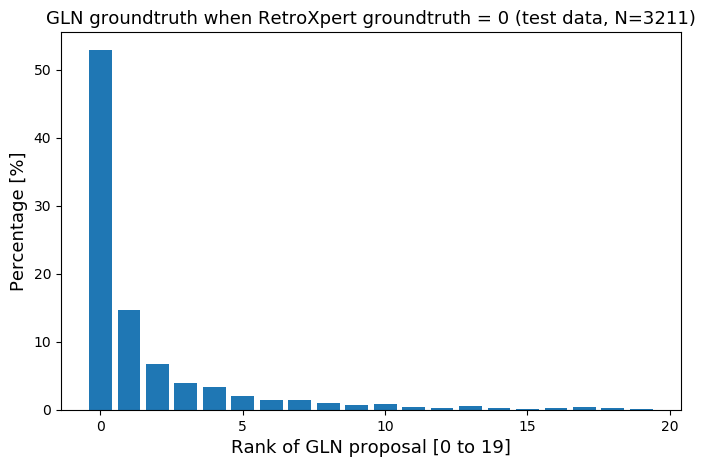

,gln_true_rank,retroxpert_true_rank
gln_true_rank,1.000000,-0.011912
retroxpert_true_rank,-0.011912,1.000000


In [10]:
phase = 'test'

retroxpert_props = pd.read_csv(f'rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
retroxpert_props = retroxpert_props.fillna('9999') 
retroxpert_props_np = retroxpert_props.values 

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values 
    
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retroxpert_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retroxpert_true_rank']
ranks_combined = ranks_combined.astype('int')

topk = 20
gln_gt_dist = ranks_combined[ranks_combined['retroxpert_true_rank'] == 0].gln_true_rank.value_counts().to_dict()
for key in range(0, topk): # for plotting bar graph
    if key not in gln_gt_dist:
        gln_gt_dist[key] = 0
        
n = topk
lengths = [ranks_combined[ranks_combined['retroxpert_true_rank'] == 0].shape[0]]
counter = Counter(gln_gt_dist) 

fig = plt.figure(figsize=(8,5), dpi = 100)   
my_list = sorted(counter.items(), key=lambda x:x[0])[ : topk]
freqs = np.array([x[1] for x in my_list]) / lengths[0] * 100  
plt.bar(np.arange(n), freqs)  

plt.xlabel(f'Rank of GLN proposal [0 to {topk-1}]', size=13)
plt.xticks(np.arange(0, topk+1, 5))
plt.ylabel('Percentage [%]', size=13) 
plt.title(f'GLN groundtruth when RetroXpert groundtruth = 0 ({phase} data, N={lengths[0]})', size=13)
plt.savefig(f'rxnebm/analysis/gln_gt_dist_retroxpert0_top{topk}_{phase}.png', bbox_inches = 'tight')
plt.show()
ranks_combined.corr()

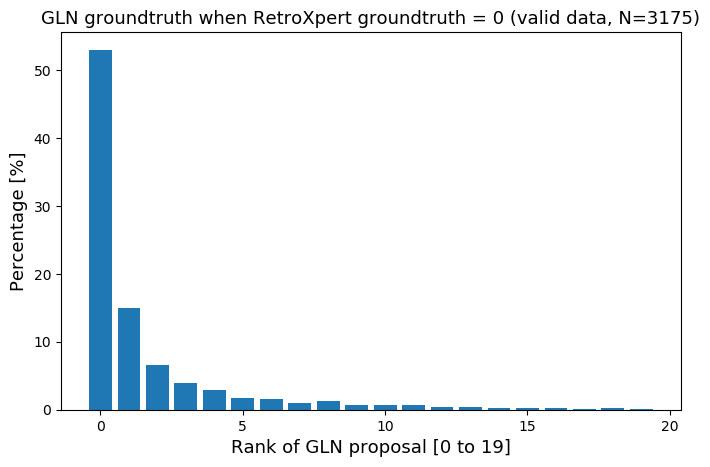

,gln_true_rank,retroxpert_true_rank
gln_true_rank,1.000000,0.001177
retroxpert_true_rank,0.001177,1.000000


In [11]:
phase = 'valid'

retroxpert_props = pd.read_csv(f'rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
retroxpert_props = retroxpert_props.fillna('9999') 
retroxpert_props_np = retroxpert_props.values 

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values 
    
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retroxpert_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retroxpert_true_rank']
ranks_combined = ranks_combined.astype('int')

topk = 20
gln_gt_dist = ranks_combined[ranks_combined['retroxpert_true_rank'] == 0].gln_true_rank.value_counts().to_dict()
for key in range(0, topk): # for plotting bar graph
    if key not in gln_gt_dist:
        gln_gt_dist[key] = 0
        
n = topk
lengths = [ranks_combined[ranks_combined['retroxpert_true_rank'] == 0].shape[0]]
counter = Counter(gln_gt_dist) 

fig = plt.figure(figsize=(8,5), dpi = 100)   
my_list = sorted(counter.items(), key=lambda x:x[0])[ : topk]
freqs = np.array([x[1] for x in my_list]) / lengths[0] * 100  
plt.bar(np.arange(n), freqs)  

plt.xlabel(f'Rank of GLN proposal [0 to {topk-1}]', size=13)
plt.xticks(np.arange(0, topk+1, 5))
plt.ylabel('Percentage [%]', size=13) 
plt.title(f'GLN groundtruth when RetroXpert groundtruth = 0 ({phase} data, N={lengths[0]})', size=13)
plt.savefig(f'rxnebm/analysis/gln_gt_dist_retroxpert0_top{topk}_{phase}.png', bbox_inches = 'tight')
plt.show()
ranks_combined.corr()

### Retrosim vs RetroXpert

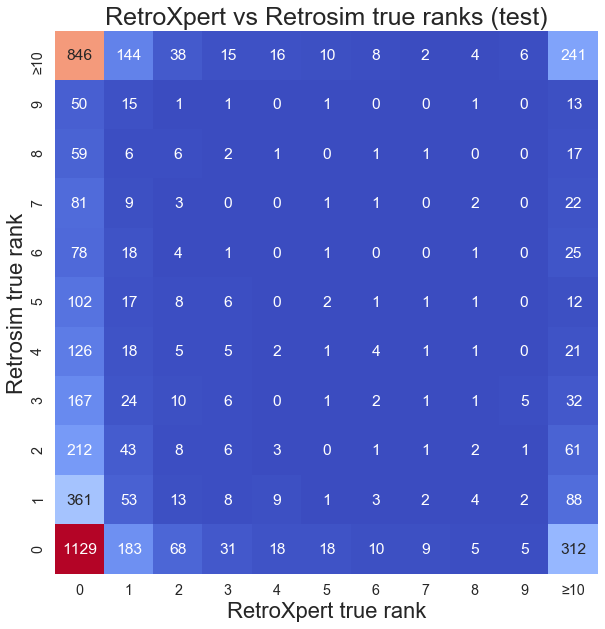

In [63]:
phase = 'test'

retroxpert_props = pd.read_csv(f'rxnebm/data/cleaned_data/retroxpert_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
retroxpert_props = retroxpert_props.fillna('9999') 
retroxpert_props_np = retroxpert_props.values 

retrosim_props = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_{phase}.csv', index_col=None, dtype='str')
retrosim_props = retrosim_props.fillna('9999') 
retrosim_props_np = retrosim_props.values 
    
ranks_combined = pd.concat([retrosim_props.rank_of_true_precursor, retroxpert_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['retrosim_true_rank', 'retroxpert_true_rank']
ranks_combined = ranks_combined.astype('int')

rank_matrix = np.zeros((11, 11), dtype='int32') # row = retrosim, col = retroxpert
for row_idx in range(ranks_combined.shape[0]):
    retrosim_true_rank = ranks_combined.iloc[row_idx, 0]
    retroxpert_true_rank = ranks_combined.iloc[row_idx, 1]
    if retrosim_true_rank > 9:
        row = 10
    else:
        row = retrosim_true_rank
    if retroxpert_true_rank > 9:
        col = 10
    else:
        col = retroxpert_true_rank
    rank_matrix[row, col] += 1

sns.set(font_scale=1.3)
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(
    data=np.flip(rank_matrix, axis=0),
    annot=True,
    cmap='coolwarm',
    fmt='',
    square=True,
    cbar=False
);

ax.set_xticklabels(list(range(10))+['≥10']);
ax.set_xlabel('RetroXpert true rank', fontsize=22);
ax.set_yticklabels(['≥10']+list(reversed(range(10))));
ax.set_ylabel('Retrosim true rank', fontsize=22);
ax.set_title(f'RetroXpert vs Retrosim true ranks ({phase})', fontsize=25);
plt.savefig(f'rxnebm/analysis/retroxpert_vs_retrosim_rank_matrix_{phase}.png', bbox_inches = 'tight')

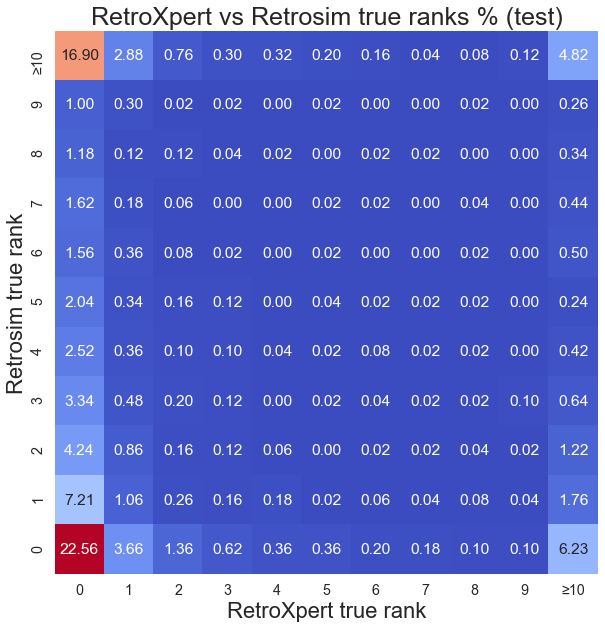

In [65]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(
    data=np.flip(rank_matrix / ranks_combined.shape[0] * 100, axis=0),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=True,
    cbar=False
);

ax.set_xticklabels(list(range(10))+['≥10']);
ax.set_xlabel('RetroXpert true rank', fontsize=22);
ax.set_yticklabels(['≥10']+list(reversed(range(10))));
ax.set_ylabel('Retrosim true rank', fontsize=22);
ax.set_title(f'RetroXpert vs Retrosim true ranks % ({phase})', fontsize=25);
plt.savefig(f'rxnebm/analysis/retroxpert_vs_retrosim_rank_matrix_perc_{phase}.png', bbox_inches = 'tight')

# pipeline everything

Avg overlaps in top-50 (ignore rank, no 9999):   	18.202 (36.404%)
Avg overlaps in top-50 (ignore rank, incl 9999): 	18.406 (36.812%)
Avg overlaps in top-50 (by exact rank, no 9999):  	1.037 (2.074%)
Avg overlaps in top-50 (by exact rank, only 9999): 	2.631 (5.262%)


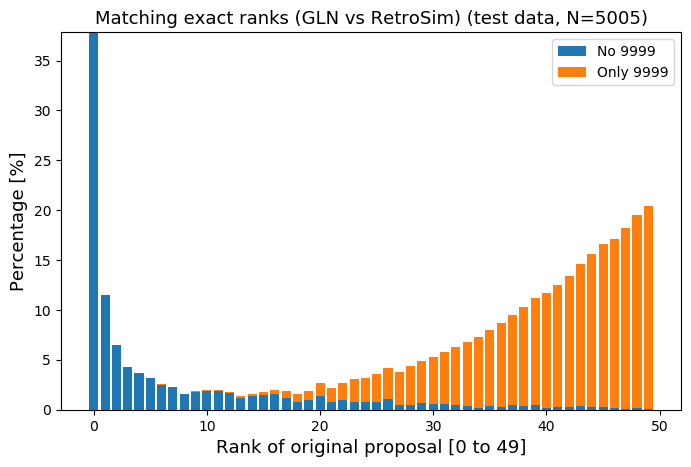

,gln_true_rank,retrosim_true_rank
gln_true_rank,1.000000,0.512354
retrosim_true_rank,0.512354,1.000000


In [124]:
phase = 'test'
topk = 50

retrosim_props = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_{phase}.csv', index_col=None, dtype='str')
retrosim_props = retrosim_props.fillna('9999') 
retrosim_props_np = retrosim_props.values  

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values  

#################### 
topk_overlap, topk_overlap_incl9999 = 0, 0
for idx in range(gln_props.shape[0]):
    gln_topk = set(gln_props_np[idx][4 : 4 + topk])
    retrosim_topk = set(retrosim_props_np[idx][4 : 4 + topk])
    
    topk_overlap_incl9999 += len(gln_topk & retrosim_topk) / gln_props.shape[0]
    
    if '9999' in gln_topk:
        gln_topk.remove('9999')
    if '9999' in retrosim_topk:
        retrosim_topk.remove('9999')
    
    topk_overlap += len(gln_topk & retrosim_topk) / gln_props.shape[0]
     
print(f'Avg overlaps in top-{topk} (ignore rank, no 9999):   \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg overlaps in top-{topk} (ignore rank, incl 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

####################
topk_overlap, topk_overlap_incl9999 = 0, 0
topk_counter, topk_counter_incl9999 = Counter(), Counter()
for idx in range(gln_props.shape[0]):
    gln_topk = gln_props_np[idx][4 : 4 + topk]
    retrosim_topk = retrosim_props_np[idx][4 : 4 + topk]

    for i, prop in enumerate(gln_topk):
        if prop == retrosim_topk[i]:
            if prop == '9999':
                topk_overlap_incl9999 += (1 / gln_props.shape[0])
                topk_counter_incl9999[i] += (1 / gln_props.shape[0])
            else: # ignore 9999
                topk_overlap += (1 / gln_props.shape[0])
                topk_counter[i] += (1 / gln_props.shape[0])
            
for i in range(topk): # fill in 0's to get same length for plotting bar graph
    if i not in topk_counter_incl9999:
        topk_counter_incl9999[i] = 0
    if i not in topk_counter:
        topk_counter[i] = 0
        
print(f'Avg overlaps in top-{topk} (by exact rank, no 9999):  \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg overlaps in top-{topk} (by exact rank, only 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

####################
n = topk
lengths = [gln_props.shape[0]]
counter = topk_counter
counter_incl9999 = topk_counter_incl9999

fig = plt.figure(figsize=(8,5), dpi = 100)   
my_list = sorted(counter.items(), key=lambda x:x[0])  
freqs = np.array([x[1] for x in my_list]) * 100  
plt.bar(np.arange(n), freqs)

my_list_incl9999 = sorted(counter_incl9999.items(), key=lambda x:x[0])  
freqs_incl9999 = np.array([x[1] for x in my_list_incl9999]) * 100
plt.bar(np.arange(n), freqs_incl9999, bottom=freqs)
plt.xlabel(f'Rank of original proposal [0 to {topk-1}]', size=13)
plt.ylabel('Percentage [%]', size=13)
plt.legend(['No 9999', 'Only 9999']) 
plt.title(f'Matching exact ranks (GLN vs RetroSim) ({phase} data, N={lengths[0]})', size=13)
plt.savefig(f'rxnebm/analysis/retrosim_gln_exact_rank_match_top{topk}_{phase}.png', bbox_inches = 'tight')
plt.show()

####################
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retrosim_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retrosim_true_rank']
ranks_combined = ranks_combined.astype('int') 
ranks_combined.corr()

Avg overlaps in top-50 (ignore rank, no 9999):   	18.128 (36.257%)
Avg overlaps in top-50 (ignore rank, incl 9999): 	18.323 (36.645%)
Avg overlaps in top-50 (by exact rank, no 9999):  	1.026 (2.053%)
Avg overlaps in top-50 (by exact rank, only 9999): 	2.641 (5.282%)


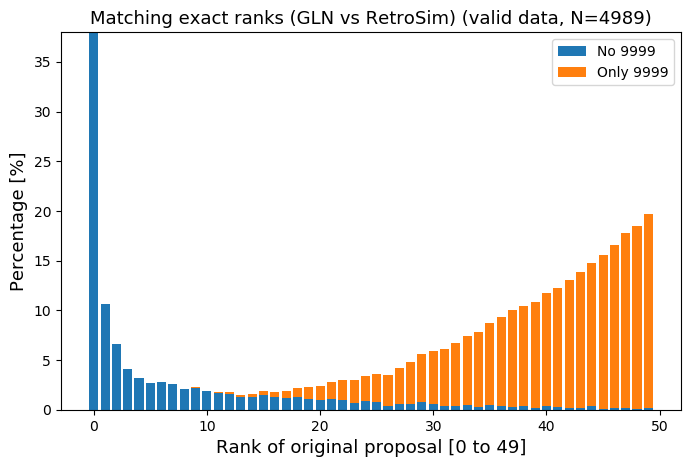

,gln_true_rank,retrosim_true_rank
gln_true_rank,1.000000,0.468192
retrosim_true_rank,0.468192,1.000000


In [123]:
phase = 'valid'
topk = 50

retrosim_props = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_{phase}.csv', index_col=None, dtype='str')
retrosim_props = retrosim_props.fillna('9999') 
retrosim_props_np = retrosim_props.values  

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values  

#################### 
topk_overlap, topk_overlap_incl9999 = 0, 0
for idx in range(gln_props.shape[0]):
    gln_topk = set(gln_props_np[idx][4 : 4 + topk])
    retrosim_topk = set(retrosim_props_np[idx][4 : 4 + topk])
    
    topk_overlap_incl9999 += len(gln_topk & retrosim_topk) / gln_props.shape[0]
    
    if '9999' in gln_topk:
        gln_topk.remove('9999')
    if '9999' in retrosim_topk:
        retrosim_topk.remove('9999')
    
    topk_overlap += len(gln_topk & retrosim_topk) / gln_props.shape[0]
     
print(f'Avg overlaps in top-{topk} (ignore rank, no 9999):   \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg overlaps in top-{topk} (ignore rank, incl 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

####################
topk_overlap, topk_overlap_incl9999 = 0, 0
topk_counter, topk_counter_incl9999 = Counter(), Counter()
for idx in range(gln_props.shape[0]):
    gln_topk = gln_props_np[idx][4 : 4 + topk]
    retrosim_topk = retrosim_props_np[idx][4 : 4 + topk]

    for i, prop in enumerate(gln_topk):
        if prop == retrosim_topk[i]:
            if prop == '9999':
                topk_overlap_incl9999 += (1 / gln_props.shape[0])
                topk_counter_incl9999[i] += (1 / gln_props.shape[0])
            else: # ignore 9999
                topk_overlap += (1 / gln_props.shape[0])
                topk_counter[i] += (1 / gln_props.shape[0])
            
for i in range(topk): # fill in 0's to get same length for plotting bar graph
    if i not in topk_counter_incl9999:
        topk_counter_incl9999[i] = 0
    if i not in topk_counter:
        topk_counter[i] = 0
        
print(f'Avg overlaps in top-{topk} (by exact rank, no 9999):  \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg overlaps in top-{topk} (by exact rank, only 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

####################
n = topk
lengths = [gln_props.shape[0]]
counter = topk_counter
counter_incl9999 = topk_counter_incl9999

fig = plt.figure(figsize=(8,5), dpi = 100)   
my_list = sorted(counter.items(), key=lambda x:x[0])  
freqs = np.array([x[1] for x in my_list]) * 100  
plt.bar(np.arange(n), freqs)

my_list_incl9999 = sorted(counter_incl9999.items(), key=lambda x:x[0])  
freqs_incl9999 = np.array([x[1] for x in my_list_incl9999]) * 100
plt.bar(np.arange(n), freqs_incl9999, bottom=freqs)
plt.xlabel(f'Rank of original proposal [0 to {topk-1}]', size=13)
plt.ylabel('Percentage [%]', size=13)
plt.legend(['No 9999', 'Only 9999']) 
plt.title(f'Matching exact ranks (GLN vs RetroSim) ({phase} data, N={lengths[0]})', size=13)
plt.savefig(f'rxnebm/analysis/retrosim_gln_exact_rank_match_top{topk}_{phase}.png', bbox_inches = 'tight')
plt.show()

####################
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retrosim_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retrosim_true_rank']
ranks_combined = ranks_combined.astype('int') 
ranks_combined.corr()

Avg overlaps in top-100 (ignore rank, no 9999):   	23.154 (23.154%)
Avg overlaps in top-100 (ignore rank, incl 9999): 	23.877 (23.877%)
Avg overlaps in top-100 (by exact rank, no 9999):  	1.037 (1.037%)
Avg overlaps in top-100 (by exact rank, only 9999): 	26.112 (26.112%)


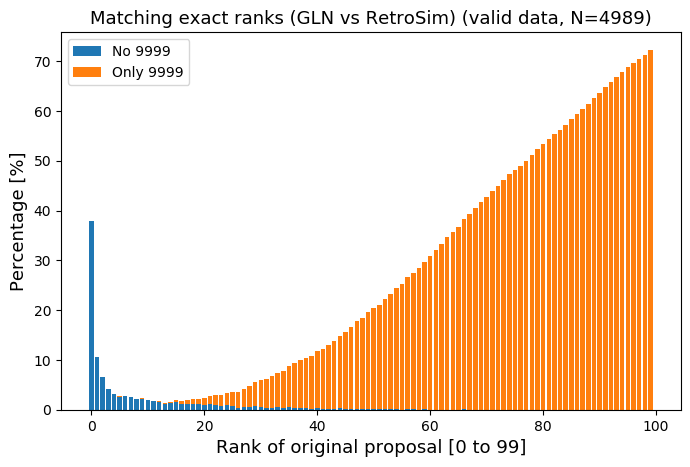

,gln_true_rank,retrosim_true_rank
gln_true_rank,1.000000,0.468192
retrosim_true_rank,0.468192,1.000000


In [127]:
phase = 'valid'
topk = 100

retrosim_props = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_{phase}.csv', index_col=None, dtype='str')
retrosim_props = retrosim_props.fillna('9999') 
retrosim_props_np = retrosim_props.values  

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values  

#################### 
topk_overlap, topk_overlap_incl9999 = 0, 0
for idx in range(gln_props.shape[0]):
    gln_topk = set(gln_props_np[idx][4 : 4 + topk])
    retrosim_topk = set(retrosim_props_np[idx][4 : 4 + topk])
    
    topk_overlap_incl9999 += len(gln_topk & retrosim_topk) / gln_props.shape[0]
    
    if '9999' in gln_topk:
        gln_topk.remove('9999')
    if '9999' in retrosim_topk:
        retrosim_topk.remove('9999')
    
    topk_overlap += len(gln_topk & retrosim_topk) / gln_props.shape[0]
     
print(f'Avg overlaps in top-{topk} (ignore rank, no 9999):   \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg overlaps in top-{topk} (ignore rank, incl 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

####################
topk_overlap, topk_overlap_incl9999 = 0, 0
topk_counter, topk_counter_incl9999 = Counter(), Counter()
for idx in range(gln_props.shape[0]):
    gln_topk = gln_props_np[idx][4 : 4 + topk]
    retrosim_topk = retrosim_props_np[idx][4 : 4 + topk]

    for i, prop in enumerate(gln_topk):
        if prop == retrosim_topk[i]:
            if prop == '9999':
                topk_overlap_incl9999 += (1 / gln_props.shape[0])
                topk_counter_incl9999[i] += (1 / gln_props.shape[0])
            else: # ignore 9999
                topk_overlap += (1 / gln_props.shape[0])
                topk_counter[i] += (1 / gln_props.shape[0])
            
for i in range(topk): # fill in 0's to get same length for plotting bar graph
    if i not in topk_counter_incl9999:
        topk_counter_incl9999[i] = 0
    if i not in topk_counter:
        topk_counter[i] = 0
        
print(f'Avg overlaps in top-{topk} (by exact rank, no 9999):  \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg overlaps in top-{topk} (by exact rank, only 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

####################
n = topk
lengths = [gln_props.shape[0]]
counter = topk_counter
counter_incl9999 = topk_counter_incl9999

fig = plt.figure(figsize=(8,5), dpi = 100)   
my_list = sorted(counter.items(), key=lambda x:x[0])  
freqs = np.array([x[1] for x in my_list]) * 100  
plt.bar(np.arange(n), freqs)

my_list_incl9999 = sorted(counter_incl9999.items(), key=lambda x:x[0])  
freqs_incl9999 = np.array([x[1] for x in my_list_incl9999]) * 100
plt.bar(np.arange(n), freqs_incl9999, bottom=freqs)
plt.xlabel(f'Rank of original proposal [0 to {topk-1}]', size=13)
plt.ylabel('Percentage [%]', size=13)
plt.legend(['No 9999', 'Only 9999']) 
plt.title(f'Matching exact ranks (GLN vs RetroSim) ({phase} data, N={lengths[0]})', size=13)
plt.savefig(f'rxnebm/analysis/retrosim_gln_exact_rank_match_top{topk}_{phase}.png', bbox_inches = 'tight')
plt.show()

####################
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retrosim_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retrosim_true_rank']
ranks_combined = ranks_combined.astype('int') 
ranks_combined.corr()

Avg overlaps in top-100 (ignore rank, no 9999):   	23.253 (23.253%)
Avg overlaps in top-100 (ignore rank, incl 9999): 	23.973 (23.973%)
Avg overlaps in top-100 (by exact rank, no 9999):  	1.048 (1.048%)
Avg overlaps in top-100 (by exact rank, only 9999): 	26.594 (26.594%)


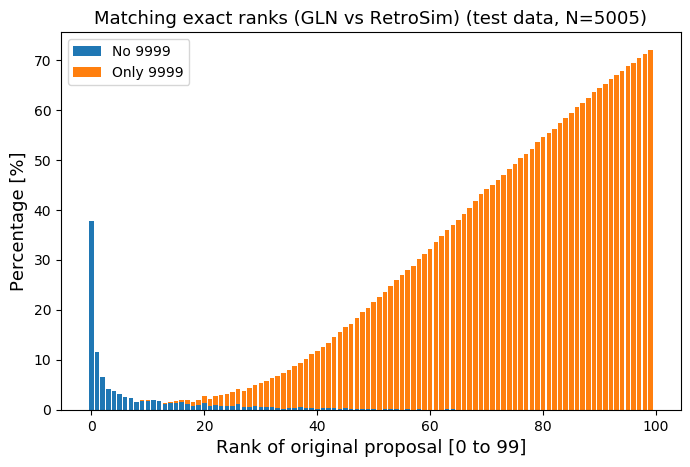

,gln_true_rank,retrosim_true_rank
gln_true_rank,1.000000,0.512354
retrosim_true_rank,0.512354,1.000000


In [128]:
phase = 'test'
topk = 100

retrosim_props = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_{phase}.csv', index_col=None, dtype='str')
retrosim_props = retrosim_props.fillna('9999') 
retrosim_props_np = retrosim_props.values  

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values  

#################### 
topk_overlap, topk_overlap_incl9999 = 0, 0
for idx in range(gln_props.shape[0]):
    gln_topk = set(gln_props_np[idx][4 : 4 + topk])
    retrosim_topk = set(retrosim_props_np[idx][4 : 4 + topk])
    
    topk_overlap_incl9999 += len(gln_topk & retrosim_topk) / gln_props.shape[0]
    
    if '9999' in gln_topk:
        gln_topk.remove('9999')
    if '9999' in retrosim_topk:
        retrosim_topk.remove('9999')
    
    topk_overlap += len(gln_topk & retrosim_topk) / gln_props.shape[0]
     
print(f'Avg overlaps in top-{topk} (ignore rank, no 9999):   \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg overlaps in top-{topk} (ignore rank, incl 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

####################
topk_overlap, topk_overlap_incl9999 = 0, 0
topk_counter, topk_counter_incl9999 = Counter(), Counter()
for idx in range(gln_props.shape[0]):
    gln_topk = gln_props_np[idx][4 : 4 + topk]
    retrosim_topk = retrosim_props_np[idx][4 : 4 + topk]

    for i, prop in enumerate(gln_topk):
        if prop == retrosim_topk[i]:
            if prop == '9999':
                topk_overlap_incl9999 += (1 / gln_props.shape[0])
                topk_counter_incl9999[i] += (1 / gln_props.shape[0])
            else: # ignore 9999
                topk_overlap += (1 / gln_props.shape[0])
                topk_counter[i] += (1 / gln_props.shape[0])
            
for i in range(topk): # fill in 0's to get same length for plotting bar graph
    if i not in topk_counter_incl9999:
        topk_counter_incl9999[i] = 0
    if i not in topk_counter:
        topk_counter[i] = 0
        
print(f'Avg overlaps in top-{topk} (by exact rank, no 9999):  \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg overlaps in top-{topk} (by exact rank, only 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

####################
n = topk
lengths = [gln_props.shape[0]]
counter = topk_counter
counter_incl9999 = topk_counter_incl9999

fig = plt.figure(figsize=(8,5), dpi = 100)   
my_list = sorted(counter.items(), key=lambda x:x[0])  
freqs = np.array([x[1] for x in my_list]) * 100  
plt.bar(np.arange(n), freqs)

my_list_incl9999 = sorted(counter_incl9999.items(), key=lambda x:x[0])  
freqs_incl9999 = np.array([x[1] for x in my_list_incl9999]) * 100
plt.bar(np.arange(n), freqs_incl9999, bottom=freqs)
plt.xlabel(f'Rank of original proposal [0 to {topk-1}]', size=13)
plt.ylabel('Percentage [%]', size=13)
plt.legend(['No 9999', 'Only 9999']) 
plt.title(f'Matching exact ranks (GLN vs RetroSim) ({phase} data, N={lengths[0]})', size=13)
plt.savefig(f'rxnebm/analysis/retrosim_gln_exact_rank_match_top{topk}_{phase}.png', bbox_inches = 'tight')
plt.show()

####################
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retrosim_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retrosim_true_rank']
ranks_combined = ranks_combined.astype('int') 
ranks_combined.corr()

## with top200, reminder RetroSim on avg only propose 37.5/prod, so the large number of 9999's is expected

Avg overlaps in top-200 (ignore rank, no 9999):   	23.720 (11.860%)
Avg overlaps in top-200 (ignore rank, incl 9999): 	24.720 (12.360%)
Avg overlaps in top-200 (by exact rank, no 9999):  	1.037 (0.519%)
Avg overlaps in top-200 (by exact rank, only 9999): 	120.603 (60.301%)


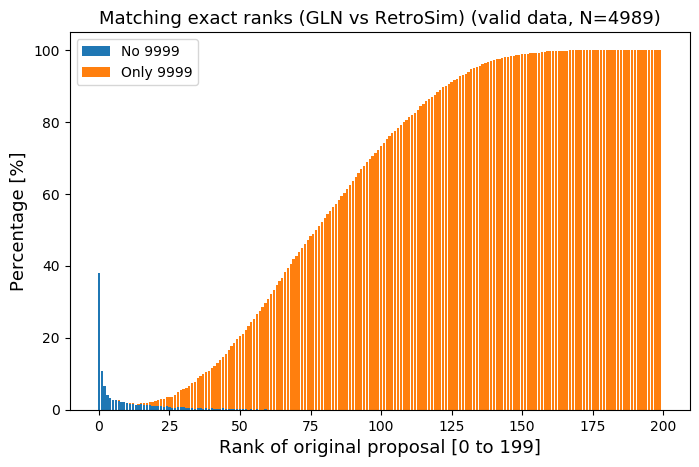

,gln_true_rank,retrosim_true_rank
gln_true_rank,1.000000,0.468192
retrosim_true_rank,0.468192,1.000000


In [129]:
phase = 'valid'
topk = 200

retrosim_props = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_{phase}.csv', index_col=None, dtype='str')
retrosim_props = retrosim_props.fillna('9999') 
retrosim_props_np = retrosim_props.values  

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values  

#################### 
topk_overlap, topk_overlap_incl9999 = 0, 0
for idx in range(gln_props.shape[0]):
    gln_topk = set(gln_props_np[idx][4 : 4 + topk])
    retrosim_topk = set(retrosim_props_np[idx][4 : 4 + topk])
    
    topk_overlap_incl9999 += len(gln_topk & retrosim_topk) / gln_props.shape[0]
    
    if '9999' in gln_topk:
        gln_topk.remove('9999')
    if '9999' in retrosim_topk:
        retrosim_topk.remove('9999')
    
    topk_overlap += len(gln_topk & retrosim_topk) / gln_props.shape[0]
     
print(f'Avg overlaps in top-{topk} (ignore rank, no 9999):   \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg overlaps in top-{topk} (ignore rank, incl 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

####################
topk_overlap, topk_overlap_incl9999 = 0, 0
topk_counter, topk_counter_incl9999 = Counter(), Counter()
for idx in range(gln_props.shape[0]):
    gln_topk = gln_props_np[idx][4 : 4 + topk]
    retrosim_topk = retrosim_props_np[idx][4 : 4 + topk]

    for i, prop in enumerate(gln_topk):
        if prop == retrosim_topk[i]:
            if prop == '9999':
                topk_overlap_incl9999 += (1 / gln_props.shape[0])
                topk_counter_incl9999[i] += (1 / gln_props.shape[0])
            else: # ignore 9999
                topk_overlap += (1 / gln_props.shape[0])
                topk_counter[i] += (1 / gln_props.shape[0])
            
for i in range(topk): # fill in 0's to get same length for plotting bar graph
    if i not in topk_counter_incl9999:
        topk_counter_incl9999[i] = 0
    if i not in topk_counter:
        topk_counter[i] = 0
        
print(f'Avg overlaps in top-{topk} (by exact rank, no 9999):  \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg overlaps in top-{topk} (by exact rank, only 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

####################
n = topk
lengths = [gln_props.shape[0]]
counter = topk_counter
counter_incl9999 = topk_counter_incl9999

fig = plt.figure(figsize=(8,5), dpi = 100)   
my_list = sorted(counter.items(), key=lambda x:x[0])  
freqs = np.array([x[1] for x in my_list]) * 100  
plt.bar(np.arange(n), freqs)

my_list_incl9999 = sorted(counter_incl9999.items(), key=lambda x:x[0])  
freqs_incl9999 = np.array([x[1] for x in my_list_incl9999]) * 100
plt.bar(np.arange(n), freqs_incl9999, bottom=freqs)
plt.xlabel(f'Rank of original proposal [0 to {topk-1}]', size=13)
plt.ylabel('Percentage [%]', size=13)
plt.legend(['No 9999', 'Only 9999']) 
plt.title(f'Matching exact ranks (GLN vs RetroSim) ({phase} data, N={lengths[0]})', size=13)
plt.savefig(f'rxnebm/analysis/retrosim_gln_exact_rank_match_top{topk}_{phase}.png', bbox_inches = 'tight')
plt.show()

####################
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retrosim_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retrosim_true_rank']
ranks_combined = ranks_combined.astype('int') 
ranks_combined.corr()

Avg overlaps in top-200 (ignore rank, no 9999):   	23.814 (11.907%)
Avg overlaps in top-200 (ignore rank, incl 9999): 	24.814 (12.407%)
Avg overlaps in top-200 (by exact rank, no 9999):  	1.048 (0.524%)
Avg overlaps in top-200 (by exact rank, only 9999): 	120.928 (60.464%)


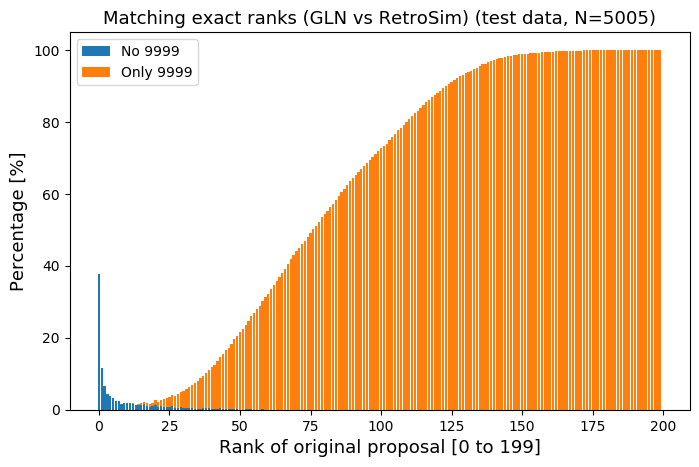

,gln_true_rank,retrosim_true_rank
gln_true_rank,1.000000,0.512354
retrosim_true_rank,0.512354,1.000000


In [130]:
phase = 'test'
topk = 200

retrosim_props = pd.read_csv(f'rxnebm/data/cleaned_data/retrosim_200maxtest_200maxprec_{phase}.csv', index_col=None, dtype='str')
retrosim_props = retrosim_props.fillna('9999') 
retrosim_props_np = retrosim_props.values  

gln_props = pd.read_csv(f'rxnebm/data/cleaned_data/GLN_200topk_200maxk_200beam_{phase}.csv', index_col=None, dtype='str')
gln_props = gln_props.fillna('9999') 
gln_props_np = gln_props.values  

#################### 
topk_overlap, topk_overlap_incl9999 = 0, 0
for idx in range(gln_props.shape[0]):
    gln_topk = set(gln_props_np[idx][4 : 4 + topk])
    retrosim_topk = set(retrosim_props_np[idx][4 : 4 + topk])
    
    topk_overlap_incl9999 += len(gln_topk & retrosim_topk) / gln_props.shape[0]
    
    if '9999' in gln_topk:
        gln_topk.remove('9999')
    if '9999' in retrosim_topk:
        retrosim_topk.remove('9999')
    
    topk_overlap += len(gln_topk & retrosim_topk) / gln_props.shape[0]
     
print(f'Avg overlaps in top-{topk} (ignore rank, no 9999):   \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg overlaps in top-{topk} (ignore rank, incl 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

####################
topk_overlap, topk_overlap_incl9999 = 0, 0
topk_counter, topk_counter_incl9999 = Counter(), Counter()
for idx in range(gln_props.shape[0]):
    gln_topk = gln_props_np[idx][4 : 4 + topk]
    retrosim_topk = retrosim_props_np[idx][4 : 4 + topk]

    for i, prop in enumerate(gln_topk):
        if prop == retrosim_topk[i]:
            if prop == '9999':
                topk_overlap_incl9999 += (1 / gln_props.shape[0])
                topk_counter_incl9999[i] += (1 / gln_props.shape[0])
            else: # ignore 9999
                topk_overlap += (1 / gln_props.shape[0])
                topk_counter[i] += (1 / gln_props.shape[0])
            
for i in range(topk): # fill in 0's to get same length for plotting bar graph
    if i not in topk_counter_incl9999:
        topk_counter_incl9999[i] = 0
    if i not in topk_counter:
        topk_counter[i] = 0
        
print(f'Avg overlaps in top-{topk} (by exact rank, no 9999):  \t{topk_overlap:.3f} ({topk_overlap / topk * 100:.3f}%)')
print(f'Avg overlaps in top-{topk} (by exact rank, only 9999): \t{topk_overlap_incl9999:.3f} ({topk_overlap_incl9999 / topk * 100:.3f}%)')

####################
n = topk
lengths = [gln_props.shape[0]]
counter = topk_counter
counter_incl9999 = topk_counter_incl9999

fig = plt.figure(figsize=(8,5), dpi = 100)   
my_list = sorted(counter.items(), key=lambda x:x[0])  
freqs = np.array([x[1] for x in my_list]) * 100  
plt.bar(np.arange(n), freqs)

my_list_incl9999 = sorted(counter_incl9999.items(), key=lambda x:x[0])  
freqs_incl9999 = np.array([x[1] for x in my_list_incl9999]) * 100
plt.bar(np.arange(n), freqs_incl9999, bottom=freqs)
plt.xlabel(f'Rank of original proposal [0 to {topk-1}]', size=13)
plt.ylabel('Percentage [%]', size=13)
plt.legend(['No 9999', 'Only 9999']) 
plt.title(f'Matching exact ranks (GLN vs RetroSim) ({phase} data, N={lengths[0]})', size=13)
plt.savefig(f'rxnebm/analysis/retrosim_gln_exact_rank_match_top{topk}_{phase}.png', bbox_inches = 'tight')
plt.show()

####################
ranks_combined = pd.concat([gln_props.rank_of_true_precursor, retrosim_props.rank_of_true_precursor], axis=1)
ranks_combined.columns = ['gln_true_rank', 'retrosim_true_rank']
ranks_combined = ranks_combined.astype('int') 
ranks_combined.corr()